In [2]:
# Install necessary dependencies
%pip install graphdatascience


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from graphdatascience import GraphDataScience
import json
import numpy as np
import pandas as pd

# Get Neo4j DB URI, credentials and name from environment if applicable
gds = GraphDataScience( "bolt://localhost:7687", auth=('neo4j', '88888888'))




In [4]:
CORA_CONTENT = "https://data.neo4j.com/cora/cora.content"
CORA_CITES = "https://data.neo4j.com/cora/cora.cites"

In [6]:
import random
import csv
import requests
from io import StringIO

# 下载CORA_CITES数据集
response = requests.get("https://data.neo4j.com/cora/cora.cites")
cites_data = response.text.split("\n")

# 提取CORA_CITES数据集中的论文对
cora_paper_pairs = [(int(line.split(',')[0]), int(line.split(',')[1])) for line in cites_data if len(line.split(',')) == 2]

# 确定论文对的总数
total_paper_pairs = len(cora_paper_pairs)

# 计算80%的论文对数量
eighty_percent = int(0.8 * total_paper_pairs)

# 随机选择80%的论文对
random_paper_pairs = random.sample(cora_paper_pairs, eighty_percent)

# 将随机抽样的论文对写入CSV文件
with open('random_paper_pairs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Paper 1", "Paper 2"])  # 写入表头
    writer.writerows(random_paper_pairs)

# 剩下的20%的论文对
remaining_paper_pairs = [pair for pair in cora_paper_pairs if pair not in random_paper_pairs]

# 将剩下的20%的论文对写入CSV文件
with open('remaining_paper_pairs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Paper 1", "Paper 2"])  # 写入表头
    writer.writerows(remaining_paper_pairs)




In [7]:
SUBJECT_TO_ID = {
    "Neural_Networks": 100,
    "Rule_Learning": 1,
    "Reinforcement_Learning": 2,
    "Probabilistic_Methods": 3,
    "Theory": 4,
    "Genetic_Algorithms": 5,
    "Case_Based": 6,
}

HOLDOUT_NODES = 10

In [8]:
# Define a string representation of the SUBJECT_TO_ID map using backticks
subject_map = json.dumps(SUBJECT_TO_ID).replace('"', "`")

# Cypher command to load the nodes using `LOAD CSV`, taking care of
# converting the string `subject` field into an integer and
# replacing the node label for the holdout nodes
load_nodes = f"""
    LOAD CSV FROM "{CORA_CONTENT}" AS row
    WITH
      {subject_map} AS subject_to_id,
      toInteger(row[0]) AS extId,
      row[1] AS subject,
      toIntegerList(row[2..]) AS features
    MERGE (p:Paper {{extId: extId, subject: subject_to_id[subject], features: features}})
"""

# Cypher command to load the relationships using `LOAD CSV`
load_relationships = f"""
    LOAD CSV FROM 'file:///random_paper_pairs.csv' AS row
    MATCH (n:Paper), (m:Paper)
    WHERE n.extId = toInteger(row[0]) AND m.extId = toInteger(row[1])
    MERGE (n)-[:CITES]->(m)
"""


# Load nodes and relationships on Neo4j
gds.run_cypher(load_nodes)
gds.run_cypher(load_relationships)

Empty DataFrame
Columns: []
Index: []

In [17]:
# Create the projected graph containing both classified and unclassified nodes
G, _ = gds.graph.project(
    "cora-graph13",
    {"Paper": {"properties": ["features"]}, },
    {"CITES": {"orientation": "UNDIRECTED"}},
)

In [18]:
result = gds.node2vec.mutate.estimate(
    G,
    mutateProperty="embedding",
    randomSeed=42,
    embeddingDimension=60,
)

print(f"Required memory for running Node2vec: {result['requiredMemory']}")

Required memory for running Node2vec: 18 MiB


In [19]:
# Now let's run FastRP and mutate our projected graph 'purchases' with the results
result = gds.node2vec.mutate(
    G,
    mutateProperty="embedding",
    randomSeed=42,
    embeddingDimension=60,
)

# Let's make sure we got an embedding for each node
print(f"Number of embedding vectors produced: {result['nodePropertiesWritten']}")



Number of embedding vectors produced: 2708


In [20]:
# Run kNN and write back to db (skipping similar relationships if cited relationships exist)
result = gds.knn.write(
    G,
    topK=5,
    nodeProperties=["embedding"],
    randomSeed=42,
    concurrency=1,
    sampleRate=1.0,
    deltaThreshold=0.0,
    writeRelationshipType="SIMILAR",
    writeProperty="score1"
)

print(f"Relationships produced: {result['relationshipsWritten']}")
print(f"Nodes compared: {result['nodesCompared']}")
print(f"Mean similarity: {result['similarityDistribution']['mean']}")


Relationships produced: 13540
Nodes compared: 2708
Mean similarity: 0.9465048935071756


In [21]:
from neo4j import GraphDatabase

In [22]:
CORA_CITES = pd.read_csv('remaining_paper_pairs.csv')
file_similar_relationships = set(zip(CORA_CITES.iloc[:, 0], CORA_CITES.iloc[:, 1]))
driver = GraphDatabase.driver( "bolt://localhost:7687", auth=('neo4j', '88888888'))
# 编写 Cypher 查询
cypher_query = """
MATCH (n1)-[r:SIMILAR]->(n2)
RETURN n1.extId AS node1, n2.extId AS node2
"""

# 执行 Cypher 查询
similar_relationships = set()
with driver.session() as session:
    result = session.run(cypher_query)
    for record in result:
        similar_relationships.add((record['node1'], record['node2']))

# 比较数据
matching_relationships = similar_relationships.intersection(file_similar_relationships)
num_matching_relationships = len(matching_relationships)

print(f"Number of matching relationships: {num_matching_relationships}")

Number of matching relationships: 633


In [9]:
print(similar_relationships)

{(1115456, 284414), (75983, 48550), (12197, 68495), (1131549, 650807), (14428, 1103969), (193347, 1129835), (19045, 593329), (1108258, 738941), (12576, 63832), (193932, 1111240), (7537, 80491), (77829, 1152564), (145134, 129287), (1130657, 112813), (162664, 31483), (10177, 249858), (1103969, 34082), (632874, 632935), (197783, 213279), (180301, 74920), (18532, 86923), (1113739, 1118332), (141171, 7532), (11148, 348305), (779960, 430574), (1136814, 1129018), (215912, 126128), (696343, 1140230), (1131267, 561364), (1107455, 1106406), (1951, 337766), (230884, 236759), (601567, 8224), (1135899, 1131607), (108047, 578649), (1116594, 853150), (267003, 1154500), (1114331, 259701), (22563, 22566), (1115291, 137849), (239829, 646357), (118079, 13205), (16485, 72101), (307336, 854434), (35863, 481073), (6155, 1130567), (315789, 1138027), (85452, 552469), (1140547, 35922), (1116146, 1110024), (1106052, 18251), (911198, 75695), (594649, 25702), (286500, 85352), (642930, 55403), (20924, 20923), (131

In [10]:
print(f"Number of cited relationships: {len(file_similar_relationships)}")

Number of cited relationships: 1086


Graphsage

In [3]:

G, _ = gds.graph.project(
    "cora-graph4",
    {"Paper": {"properties": ["features"]},},
    {"CITES": {"orientation": "UNDIRECTED"}},
)

In [25]:
wcc = gds.wcc.stream(G)

In [26]:
wcc_grouped = (
    wcc.groupby("componentId")
    .size()
    .to_frame("componentSize")
    .reset_index()
    .sort_values("componentSize", ascending=False)
    .reset_index()
)
wcc_grouped

index  componentId  componentSize
0        0            0           2308
1        8           86             26
2       75         1108              9
3      154         1955              8
4       31          364              6
..     ...          ...            ...
221     93         1443              1
222     94         1477              1
223     95         1511              1
224     97         1518              1
225    225         2700              1

[226 rows x 3 columns]

In [27]:
largest_component = wcc_grouped["componentId"][0]
start_node = wcc[wcc["componentId"] == largest_component]["nodeId"][0]

trainG, metadata = gds.alpha.graph.sample.rwr(
    "trainGraph",
    G,
    samplingRatio=0.20,
    startNodes=[int(start_node)],
    nodeLabels=["Paper"],
    relationshipTypes=["CITES"],
)

In [18]:
gds.beta.graphSage.train(
    trainG,
    modelName="articleModel2",
    embeddingDimension=255,
    sampleSizes=[10, 10],
    searchDepth=15,
    epochs=20,
    learningRate=0.0001,
    activationFunction="RELU",
    aggregator="MEAN",
    featureProperties=["features"],
    batchSize=10,
)

(GraphSageModel({'modelName': {0: 'articleModel2'}, 'modelType': {0: 'graphSage'}, 'modelInfo': {0: {'modelName': 'articleModel2', 'modelType': 'graphSage', 'metrics': {'didConverge': False, 'ranIterationsPerEpoch': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'iterationLossesPerEpoch': [[22.024073106266002, 21.669093942986063, 21.75580866186658, 21.20722582777171, 20.79891334690598, 20.743651229956622, 20.379875314749302, 20.301387885397464, 20.126960357851953, 19.745419100978943], [19.738983472132443, 19.25877944059579, 19.628460697459616, 18.8349429977414, 18.542170838333014, 18.4819734151386, 18.51409815235153, 18.384973609060456, 18.520989759920532, 17.958257326365562], [17.708257213621287, 17.652634206241462, 17.93692254957339, 17.380541020416896, 17.360165253204965, 17.33511672998754, 17.185529405285696, 17.402027201751388, 17.056375903480237, 16.827035638331186], [16.97116843948013, 16.793545401948187, 16.775601669052882, 17.073122822099755,

In [19]:
gds.beta.graphSage.write(
    G,
    modelName="articleModel2",
    nodeLabels=["Paper"],
    writeProperty="graphSAGE",
    relationshipTypes=["CITES"],
)

nodeCount                                                             2708
nodePropertiesWritten                                                 2708
preProcessingMillis                                                      0
computeMillis                                                         1584
writeMillis                                                            345
configuration            {'writeProperty': 'graphSAGE', 'modelName': 'a...
Name: 0, dtype: object

In [28]:
trainG.drop()
G.drop()

graphName                                                      cora-graph7
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                             2708
relationshipCount                                                     8686
configuration            {'relationshipProjection': {'CITES': {'aggrega...
density                                                           0.001185
creationTime                           2024-04-24T11:36:51.649573000+00:00
modificationTime                       2024-04-24T11:36:51.996956000+00:00
schema                   {'graphProperties': {}, 'nodes': {'Paper': {'f...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Paper': {'f...
Name: 0, dtype: object

In [7]:
G, hh = gds.graph.project(
    "cora-graph1",
    node_spec={"Paper": {"properties": ["features", "graphSAGE"]}},
    relationship_spec={"CITES": {"orientation": "UNDIRECTED"}}
)


In [38]:
result = gds.knn.write(
    G,
    topK=5,
    nodeProperties=["graphSAGE"],
    randomSeed=42,
    concurrency=1,
    sampleRate=1.0,
    deltaThreshold=0.0,
    writeRelationshipType="SIMILAR",
    writeProperty="score"
)

print(f"Relationships produced: {result['relationshipsWritten']}")
print(f"Nodes compared: {result['nodesCompared']}")
print(f"Mean similarity: {result['similarityDistribution']['mean']}")

Relationships produced: 13540
Nodes compared: 2708
Mean similarity: 0.812763570224869


In [39]:
CORA_CITES = pd.read_csv('remaining_paper_pairs.csv')
file_similar_relationships = set(zip(CORA_CITES.iloc[:, 0], CORA_CITES.iloc[:, 1]))
driver = GraphDatabase.driver( "bolt://localhost:7687", auth=('neo4j', '88888888'))
# 编写 Cypher 查询
cypher_query = """
MATCH (n1)-[r:SIMILAR]->(n2)
RETURN n1.extId AS node1, n2.extId AS node2
"""

# 执行 Cypher 查询
similar_relationships = set()
with driver.session() as session:
    result = session.run(cypher_query)
    for record in result:
        similar_relationships.add((record['node1'], record['node2']))

# 比较数据
matching_relationships = similar_relationships.intersection(file_similar_relationships)
num_matching_relationships = len(matching_relationships)

print(f"Number of matching relationships: {num_matching_relationships}")

Number of matching relationships: 544


In [40]:
print(f"Number of cited relationships: {len(file_similar_relationships)}")

Number of cited relationships: 1086


Non KG

In [ ]:
result = gds.knn.write(
    G,
    topK=100,
    nodeProperties=["features"],
    randomSeed=42,
    concurrency=1,
    sampleRate=1.0,
    deltaThreshold=0.0,
    writeRelationshipType="SIMILAR", 
    writeProperty="score"
)

print(f"Relationships produced: {result['relationshipsWritten']}")
print(f"Nodes compared: {result['nodesCompared']}")
print(f"Mean similarity: {result['similarityDistribution']['mean']}")

In [11]:
CORA_CITES = pd.read_csv('remaining_paper_pairs.csv')
file_similar_relationships = set(zip(CORA_CITES.iloc[:, 0], CORA_CITES.iloc[:, 1]))
driver = GraphDatabase.driver( "bolt://localhost:7687", auth=('neo4j', '88888888'))
# 编写 Cypher 查询
cypher_query = """
MATCH (n1)-[r:SIMILAR]->(n2)
RETURN n1.extId AS node1, n2.extId AS node2
"""

# 执行 Cypher 查询
similar_relationships = set()
with driver.session() as session:
    result = session.run(cypher_query)
    for record in result:
        similar_relationships.add((record['node1'], record['node2']))

# 比较数据
matching_relationships = similar_relationships.intersection(file_similar_relationships)
num_matching_relationships = len(matching_relationships)

print(f"Number of matching relationships: {num_matching_relationships}")

Number of matching relationships: 25


In [3]:
from neo4j import GraphDatabase
import pandas as pd
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import random

# 设置随机种子
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# 读取数据文件
CORA_CITES = pd.read_csv('remaining_paper_pairs.csv')
file_similar_relationships = set(zip(CORA_CITES.iloc[:, 0], CORA_CITES.iloc[:, 1]))

# Neo4j 驱动程序
driver = GraphDatabase.driver("bolt://localhost:7687", auth=('neo4j', '88888888'))
# 循环
for embedding_dimension in range(60, 65):
    # 构建图名称
    graph_name = f"Cora--41-{embedding_dimension}"
    
    # 创建项目图
    G, _ = gds.graph.project(
        graph_name,
        {"Paper": {"properties": ["features"]}},
        {"CITES": {"orientation": "UNDIRECTED"}}
    )
    
    # 运行 FastRP 算法并修改投影图
    result = gds.node2vec.mutate(
        G,
        mutateProperty="N2V",
        randomSeed=42,
        embeddingDimension=embedding_dimension,
        iterations=10   
    )
    # 将节点属性写入图中
    graph = gds.graph.get(graph_name)
    gds.graph.writeNodeProperties(
        graph,
        ['N2V']
    )
    # 存储损失值
    losses = result['lossPerIteration']
    print(losses)
    plt.figure(figsize=(10, 6))
    plt.plot(losses, marker='o')  # 绘制损失值，'o'表示用圆圈标记每个点

    # 设置图表标题和轴标签
    plt.title(f'Loss Per Iteration (Dimension {embedding_dimension})')
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss Value')
    plt.grid(True)
    plt.show()
    
     # 第一次运行 k 最近邻算法，使用欧氏距离，写入关系类型为 "SIMILAR1"
    result_1 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=[{"N2V":'PEARSON'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR1",
        writeProperty="score1"
    )

    # 第二次运行 k 最近邻算法，使用角距离，写入关系类型为 "SIMILAR2"
    result_2 = gds.knn.write(
     G,
        topK=5,
        nodeProperties=[{"N2V":'EUCLIDEAN'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR2",
        writeProperty="score2"
    )
    # 第3次运行 k 最近邻算法，使用PEARSON，写入关系类型为 "SIMILAR3"
    result_3 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=["N2V"],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR3",
        writeProperty="score3",
        
    )

    
    # 输出结果信息
    print(f"Embedding dimension: {embedding_dimension}")
    print(f"PEARSON Mean similarity: {result_1['similarityDistribution']['mean']}")
    print(f"EUCLIDEAN Mean similarity: {result_2['similarityDistribution']['mean']}")
    print(f"COSINE Mean similarity: {result_3['similarityDistribution']['mean']}")

    # 比较数据
    similar1_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR1]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar1_relationships.add((record['node1'], record['node2']))
    
    matching1_relationships = similar1_relationships.intersection(file_similar_relationships)
    num1_matching_relationships = len(matching1_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--PEARSON: {num1_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR1]->() REMOVE r.score1 DELETE r")
    # 比较数据
    similar2_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR2]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar2_relationships.add((record['node1'], record['node2']))
    
    matching2_relationships = similar2_relationships.intersection(file_similar_relationships)
    num2_matching_relationships = len(matching2_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--EUCLIDEAN: {num2_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR2]->() REMOVE r.score2 DELETE r")
        
    
     # 比较数据
    similar3_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR3]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar3_relationships.add((record['node1'], record['node2']))
    
    matching3_relationships = similar3_relationships.intersection(file_similar_relationships)
    num3_matching_relationships = len(matching3_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--COSINE: {num3_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR3]->() REMOVE r.score3 DELETE r")
        
        
    # 获取嵌入数据并进行PCA降维
    #embedding_data = []
    #with driver.session() as session:
        #result = session.run(f"MATCH (n) WHERE n.N2V IS NOT NULL RETURN n.N2V AS N2V")
        #for record in result:
            #embedding_data.append(record['N2V'])
    #embedding_df = pd.DataFrame(embedding_data)
    #print(len(embedding_data))
    #print(embedding_df.info())
    #print(embedding_df.isna().sum())

    
    # 使用均值填充NaN值
    #imputer = SimpleImputer(strategy='mean')
    #embedding_df_filled = pd.DataFrame(imputer.fit_transform(embedding_df))
    
    # 进行PCA降维
    #pca = PCA(n_components=2)
    #principalComponents = pca.fit_transform(embedding_df_filled)
    #principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    
    # 绘制散点图
    #plt.scatter(principalDf['PC1'], principalDf['PC2'])
    #plt.xlabel('PC1')
    #plt.ylabel('PC2')
    #plt.title(f'PCA of Embedding Data (Dimension {embedding_dimension})')
    #plt.show()
    
    # 绘制损失值图表
    




KeyboardInterrupt: 

[5888778.37290165, 4308209.0288021285, 4267090.186353746, 4245792.86452519, 4232446.588068151, 4226858.425849916, 4217517.799135599, 4211809.790758935, 4206653.945101671, 4201570.898561442]


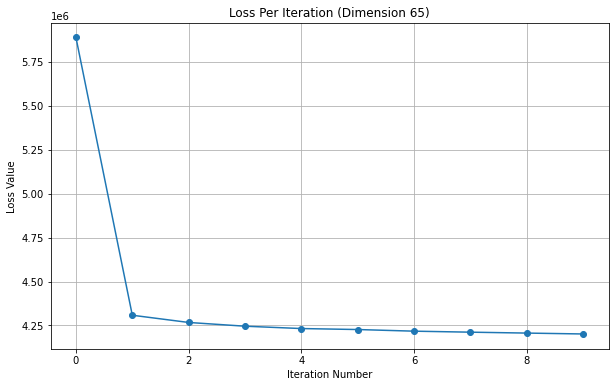

Embedding dimension: 65
PEARSON Mean similarity: 0.9233728321475504
EUCLIDEAN Mean similarity: 0.3635266635055204
COSINE Mean similarity: 0.9226243989682444
Number of matching relationships--PEARSON: 634
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 635
[5910665.185926303, 4301002.931429181, 4260096.880017807, 4242002.855158562, 4222604.42646091, 4208896.501357112, 4201266.37568628, 4193358.1097891205, 4187036.787803177, 4182939.27973543]


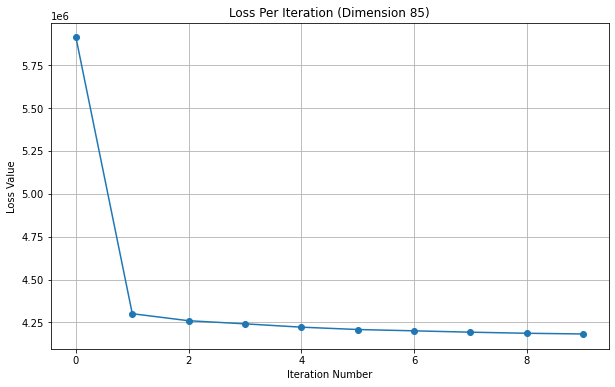

Embedding dimension: 85
PEARSON Mean similarity: 0.9165036115547754
EUCLIDEAN Mean similarity: 0.35398130057657484
COSINE Mean similarity: 0.9159500043184402
Number of matching relationships--PEARSON: 641
Number of matching relationships--EUCLIDEAN: 646
Number of matching relationships--COSINE: 642
[5932929.813814331, 4298634.782672383, 4257108.753263324, 4234975.32715798, 4219960.917323061, 4206662.173559766, 4193794.500405839, 4187409.4778791843, 4174167.1543000937, 4172130.9804846374]


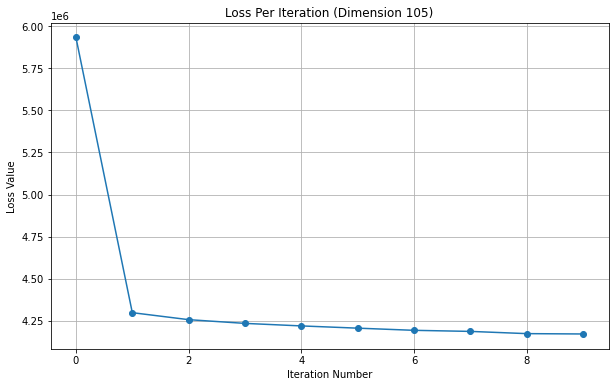

Embedding dimension: 105
PEARSON Mean similarity: 0.9118485023915504
EUCLIDEAN Mean similarity: 0.3485385769403139
COSINE Mean similarity: 0.9116581667473256
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 646
Number of matching relationships--COSINE: 630
[5937054.484285132, 4300487.813619261, 4255905.758508005, 4230849.235074465, 4210498.228899931, 4197279.309489971, 4188890.091984766, 4175650.1934505044, 4166483.635591659, 4166085.7479271665]


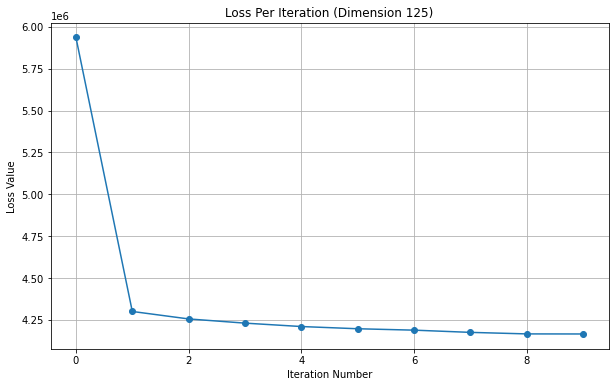

Embedding dimension: 125
PEARSON Mean similarity: 0.9094059959648279
EUCLIDEAN Mean similarity: 0.34541026640853995
COSINE Mean similarity: 0.909345950545025
Number of matching relationships--PEARSON: 626
Number of matching relationships--EUCLIDEAN: 634
Number of matching relationships--COSINE: 628
[5935239.921195822, 4297349.599975026, 4251727.231986483, 4231660.209662389, 4211979.09260286, 4197815.547968354, 4181941.807288059, 4175529.924007249, 4167577.723663356, 4162106.0706843017]


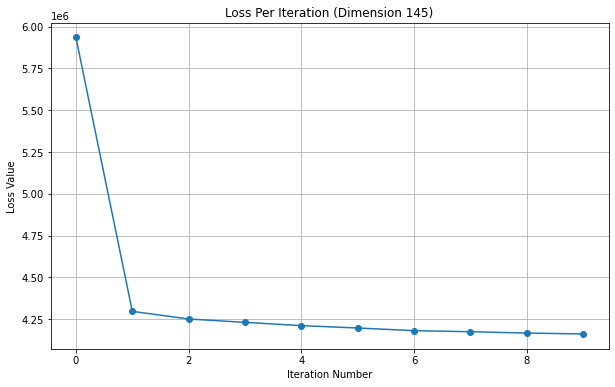

Embedding dimension: 145
PEARSON Mean similarity: 0.9081659311381893
EUCLIDEAN Mean similarity: 0.3443054391503158
COSINE Mean similarity: 0.9078708237347962
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 644
Number of matching relationships--COSINE: 631
[5970910.196869948, 4298313.798799694, 4256020.455535213, 4230134.570877044, 4210353.917978411, 4194875.992306469, 4184327.485902884, 4174974.1574592018, 4165049.5119686564, 4161340.8161650733]


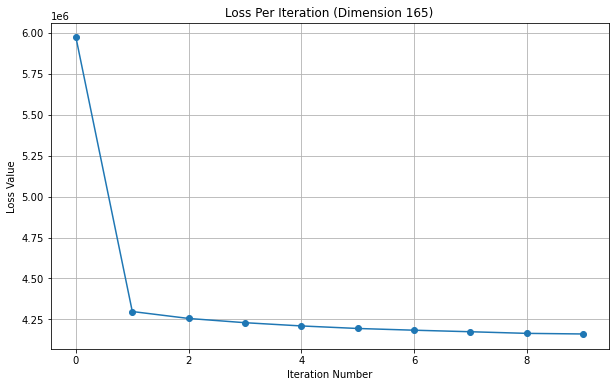

Embedding dimension: 165
PEARSON Mean similarity: 0.9070471657960066
EUCLIDEAN Mean similarity: 0.34311238560754054
COSINE Mean similarity: 0.9070042718636585
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 640
Number of matching relationships--COSINE: 628
[5955030.185620224, 4296279.567670797, 4256038.95718903, 4229495.948211201, 4210304.911086054, 4198024.287517422, 4183600.3191866176, 4174907.9240555903, 4162396.074199055, 4156981.9153903383]


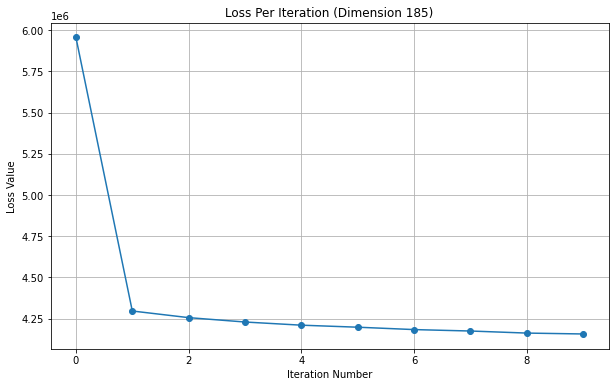

Embedding dimension: 185
PEARSON Mean similarity: 0.9057997383782571
EUCLIDEAN Mean similarity: 0.34240795653891176
COSINE Mean similarity: 0.9061511666595143
Number of matching relationships--PEARSON: 631
Number of matching relationships--EUCLIDEAN: 640
Number of matching relationships--COSINE: 632
[5984140.605220685, 4294399.077855757, 4255473.79753522, 4227268.126113902, 4212201.88579614, 4192274.8048163485, 4181728.6108782613, 4170777.525987099, 4161531.1912871157, 4155447.1866888134]


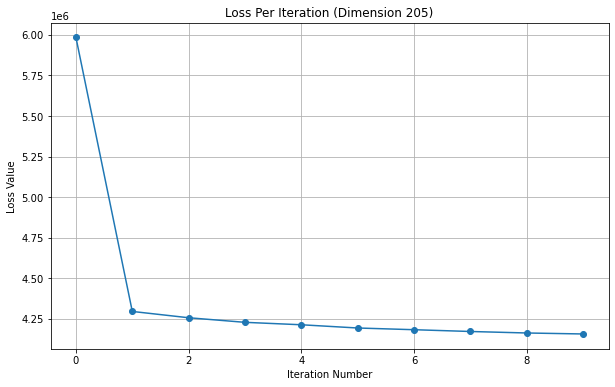

Embedding dimension: 205
PEARSON Mean similarity: 0.9058250365264306
EUCLIDEAN Mean similarity: 0.34251087088704635
COSINE Mean similarity: 0.9059358720765333
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 625
[5961463.942540921, 4298633.218386855, 4251445.065313152, 4230452.710666289, 4209591.993794804, 4196889.697111268, 4182475.240243969, 4173625.626637568, 4159616.1096623703, 4155115.056957082]


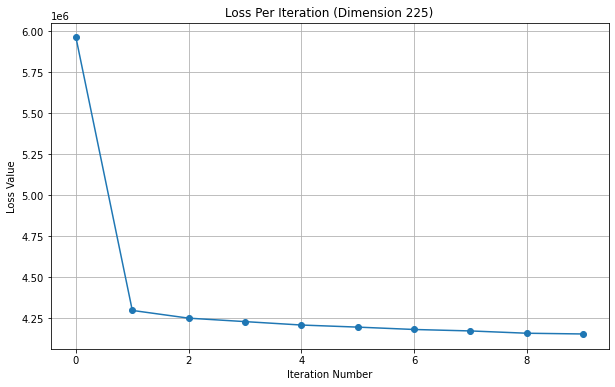

Embedding dimension: 225
PEARSON Mean similarity: 0.9056146199101007
EUCLIDEAN Mean similarity: 0.3421945668393787
COSINE Mean similarity: 0.9054946859971107
Number of matching relationships--PEARSON: 635
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 639
[5999006.218450369, 4298662.065201526, 4257065.182225969, 4226939.262234945, 4210289.554250923, 4191032.874678534, 4181248.018702538, 4168520.8346796203, 4157338.651109587, 4155382.5791045553]


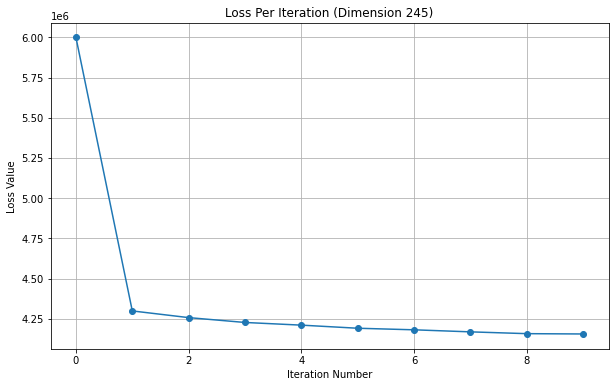

Embedding dimension: 245
PEARSON Mean similarity: 0.9051498297574425
EUCLIDEAN Mean similarity: 0.34206365862836513
COSINE Mean similarity: 0.9054610217163447
Number of matching relationships--PEARSON: 629
Number of matching relationships--EUCLIDEAN: 649
Number of matching relationships--COSINE: 630
[5987472.332110549, 4295046.427238903, 4253738.091163274, 4228727.1713688215, 4209173.391315706, 4195525.399290327, 4182718.1002478125, 4170689.676991642, 4160886.668879131, 4152301.1089664507]


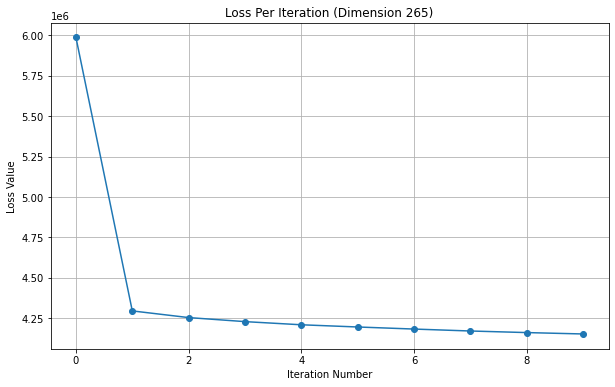

Embedding dimension: 265
PEARSON Mean similarity: 0.9051923340497376
EUCLIDEAN Mean similarity: 0.3421243066801806
COSINE Mean similarity: 0.9048104741196513
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 643
Number of matching relationships--COSINE: 630
[6016393.243775175, 4295650.688343349, 4258539.491035027, 4229741.902000501, 4208788.481124451, 4194937.535816038, 4178934.174215717, 4167859.9497326566, 4161235.69634547, 4154283.3476964375]


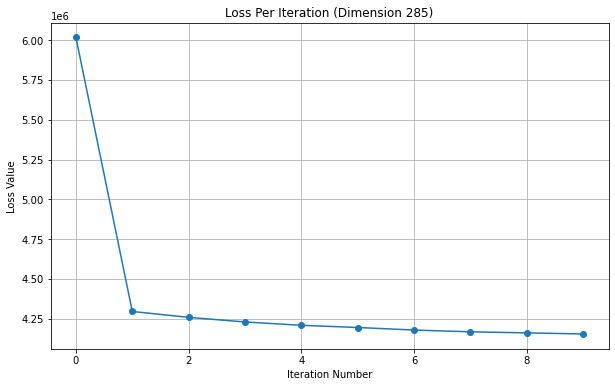

Embedding dimension: 285
PEARSON Mean similarity: 0.9050572957386822
EUCLIDEAN Mean similarity: 0.34232179178268907
COSINE Mean similarity: 0.9051394542880037
Number of matching relationships--PEARSON: 631
Number of matching relationships--EUCLIDEAN: 644
Number of matching relationships--COSINE: 632
[5987836.095276792, 4295804.116588896, 4253499.302333847, 4225010.446652183, 4206096.968709783, 4193762.5268792207, 4184950.1549664903, 4169100.9645216265, 4160787.758461342, 4153936.964306149]


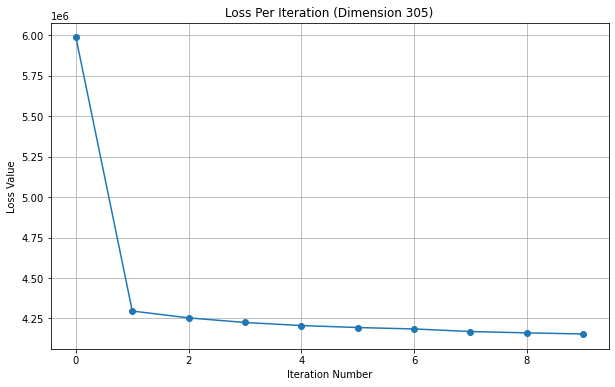

Embedding dimension: 305
PEARSON Mean similarity: 0.9045491358025916
EUCLIDEAN Mean similarity: 0.34180243469587634
COSINE Mean similarity: 0.904786703259061
Number of matching relationships--PEARSON: 633
Number of matching relationships--EUCLIDEAN: 645
Number of matching relationships--COSINE: 633
[6015802.918606155, 4295907.696272539, 4256883.425223401, 4227303.652949014, 4206071.096347203, 4192436.87910027, 4179365.624728164, 4169275.5458386955, 4160317.4801997948, 4158027.364447135]


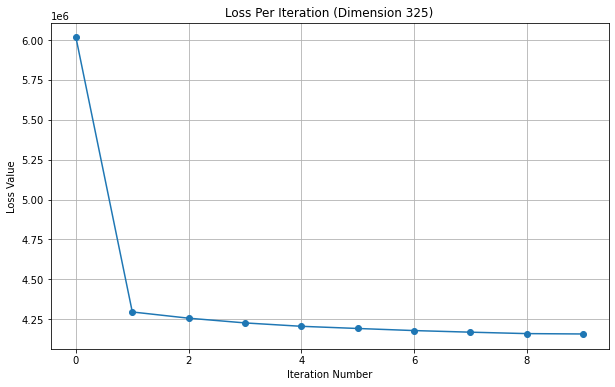

Embedding dimension: 325
PEARSON Mean similarity: 0.9044513037497043
EUCLIDEAN Mean similarity: 0.3418868140948928
COSINE Mean similarity: 0.9044244943728651
Number of matching relationships--PEARSON: 628
Number of matching relationships--EUCLIDEAN: 645
Number of matching relationships--COSINE: 627
[6007327.683502792, 4296571.345811992, 4255359.8157536965, 4230609.443583673, 4210810.921030984, 4194474.325033717, 4179851.737953049, 4167425.5885738265, 4161127.1167471022, 4152850.8414397445]


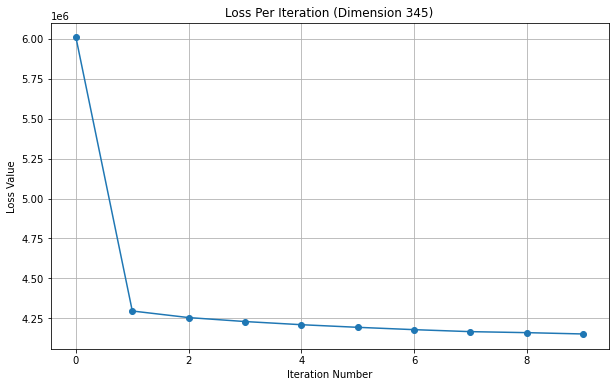

Embedding dimension: 345
PEARSON Mean similarity: 0.9048186790995971
EUCLIDEAN Mean similarity: 0.3422074590511125
COSINE Mean similarity: 0.9046576368932006
Number of matching relationships--PEARSON: 628
Number of matching relationships--EUCLIDEAN: 640
Number of matching relationships--COSINE: 629
[6015783.18077245, 4295092.860910067, 4254006.216405518, 4229511.203192889, 4212548.671594664, 4197684.638543637, 4179819.9993094946, 4168431.747832978, 4162693.848730135, 4155654.86525385]


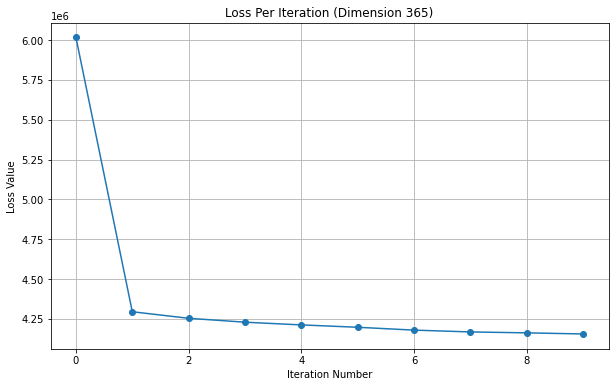

Embedding dimension: 365
PEARSON Mean similarity: 0.9047107997990077
EUCLIDEAN Mean similarity: 0.34261946100604057
COSINE Mean similarity: 0.9045122859396998
Number of matching relationships--PEARSON: 631
Number of matching relationships--EUCLIDEAN: 648
Number of matching relationships--COSINE: 631
[6029332.189293582, 4298173.598707879, 4251659.8328238325, 4228041.252775366, 4207325.001507165, 4196278.539890526, 4182363.7115600305, 4171101.0006345804, 4159560.0337802973, 4157007.232331264]


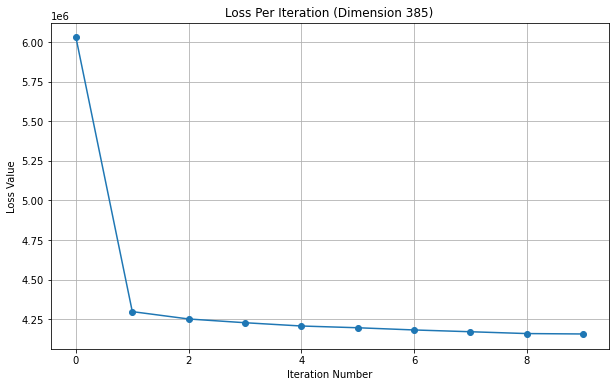

Embedding dimension: 385
PEARSON Mean similarity: 0.9046011311969165
EUCLIDEAN Mean similarity: 0.34223541318930056
COSINE Mean similarity: 0.9044488768810007
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 638
Number of matching relationships--COSINE: 624
[6047645.4298871625, 4300124.168977604, 4255095.997720819, 4229385.648858702, 4209058.158524428, 4193266.6566540413, 4181956.663321192, 4170302.3604599875, 4156986.9157061763, 4152326.547283041]


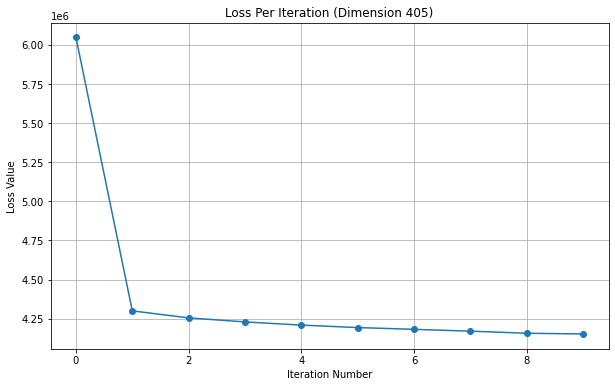

Embedding dimension: 405
PEARSON Mean similarity: 0.9045425113582188
EUCLIDEAN Mean similarity: 0.342423070304679
COSINE Mean similarity: 0.9044034504291755
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 643
Number of matching relationships--COSINE: 629
[6043238.909249231, 4294939.3275324935, 4252995.204146886, 4227135.580148362, 4206252.926559636, 4195594.694943711, 4181076.9013233664, 4172197.075564964, 4162302.895810322, 4157475.9144466016]


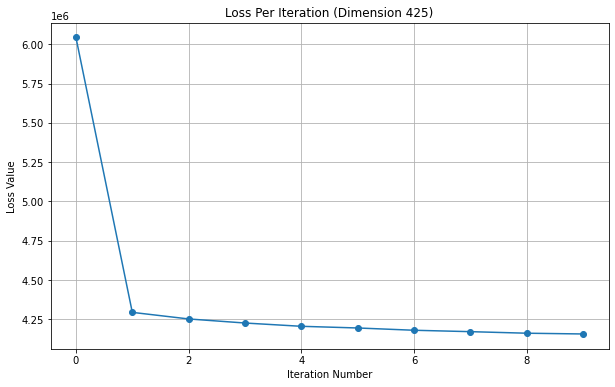

Embedding dimension: 425
PEARSON Mean similarity: 0.904744487745547
EUCLIDEAN Mean similarity: 0.3422614439199383
COSINE Mean similarity: 0.904778236546932
Number of matching relationships--PEARSON: 627
Number of matching relationships--EUCLIDEAN: 639
Number of matching relationships--COSINE: 623
[6047907.750447888, 4298119.904351442, 4252341.859147504, 4226492.077240803, 4207336.92481194, 4194959.176095729, 4179406.8563869623, 4171798.390873719, 4160889.7642436167, 4154639.7596410587]


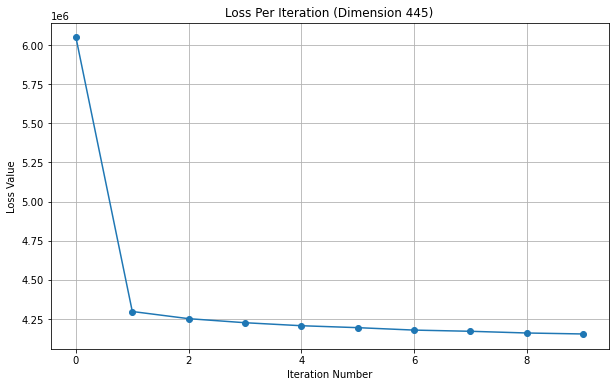

Embedding dimension: 445
PEARSON Mean similarity: 0.9041145440218544
EUCLIDEAN Mean similarity: 0.3426036479025859
COSINE Mean similarity: 0.9044285003684648
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 638
Number of matching relationships--COSINE: 630
[6037067.9988161195, 4297875.9620246375, 4254178.059345987, 4232201.092474582, 4212048.235104669, 4193701.1271569594, 4183005.126427357, 4170166.3999308096, 4159349.1907550637, 4156267.3444333947]


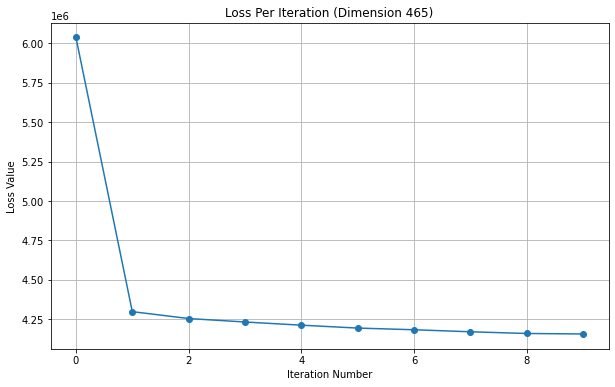

Embedding dimension: 465
PEARSON Mean similarity: 0.9044833663647425
EUCLIDEAN Mean similarity: 0.3425848455865767
COSINE Mean similarity: 0.9046223596772908
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 637
Number of matching relationships--COSINE: 625
[6060632.318188168, 4297360.62128766, 4254997.658575683, 4227465.656142491, 4211264.001789518, 4194419.390492938, 4180632.4474988915, 4169798.6328645735, 4165139.7407079125, 4159508.937732628]


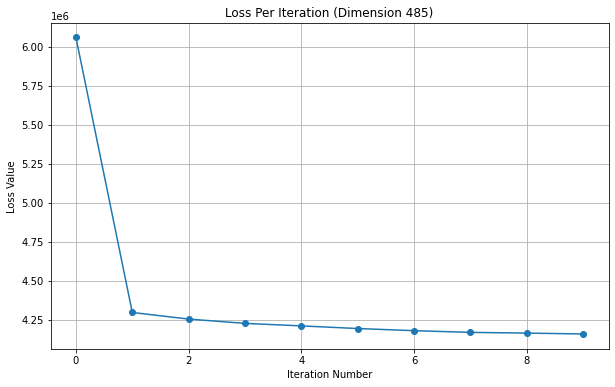

Embedding dimension: 485
PEARSON Mean similarity: 0.9042525349198627
EUCLIDEAN Mean similarity: 0.3425718623038761
COSINE Mean similarity: 0.9041571810115211
Number of matching relationships--PEARSON: 624
Number of matching relationships--EUCLIDEAN: 641
Number of matching relationships--COSINE: 628
[6042441.391733196, 4302110.808619763, 4252770.61083107, 4228256.840449234, 4210707.226084114, 4197568.292872887, 4185147.8808660237, 4172399.034996728, 4157194.0476633627, 4155976.5849667047]


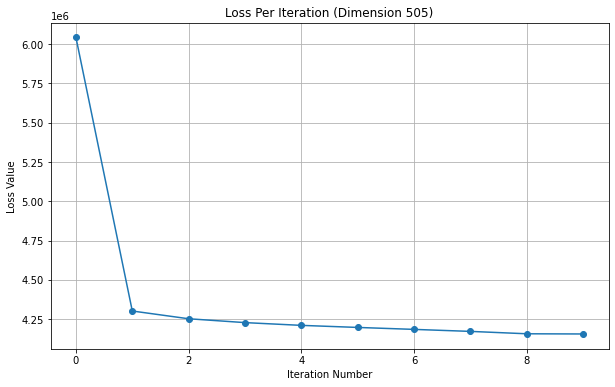

Embedding dimension: 505
PEARSON Mean similarity: 0.9044184286097833
EUCLIDEAN Mean similarity: 0.34275821836519454
COSINE Mean similarity: 0.9041570421159708
Number of matching relationships--PEARSON: 629
Number of matching relationships--EUCLIDEAN: 638
Number of matching relationships--COSINE: 625
[6070910.912483594, 4296064.04019345, 4254004.586844532, 4229339.634868467, 4213654.614212055, 4196016.709777263, 4186576.728855772, 4167976.791724059, 4158153.627095255, 4157187.612196693]


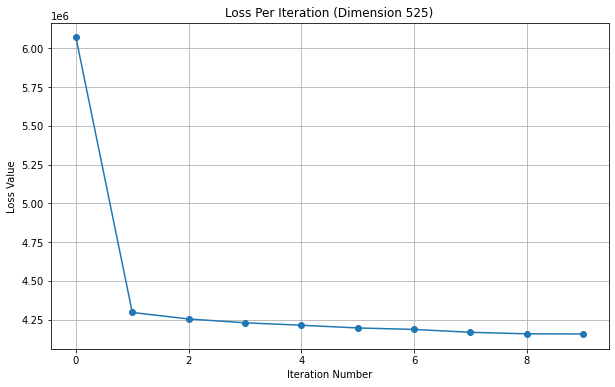

Embedding dimension: 525
PEARSON Mean similarity: 0.9040555658157327
EUCLIDEAN Mean similarity: 0.342356286760271
COSINE Mean similarity: 0.9039920373012256
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 641
Number of matching relationships--COSINE: 625
[6052861.041067078, 4297976.564014667, 4255722.171488363, 4228264.895385503, 4208127.066681387, 4196099.026857423, 4178716.861093529, 4174312.51421974, 4157727.547897656, 4156415.7205356625]


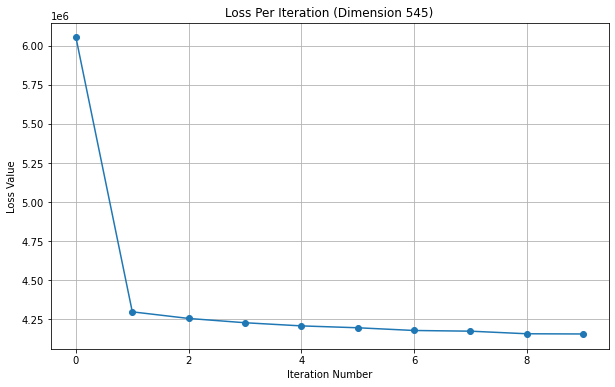

Embedding dimension: 545
PEARSON Mean similarity: 0.9041968166740113
EUCLIDEAN Mean similarity: 0.3425536529000084
COSINE Mean similarity: 0.9042192701398886
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 640
Number of matching relationships--COSINE: 628
[6065064.140121881, 4298956.1045243, 4257359.171889935, 4226863.392922757, 4209970.135840638, 4196687.966263355, 4181341.367586384, 4168329.8861162486, 4162931.9434934426, 4156991.5537313554]


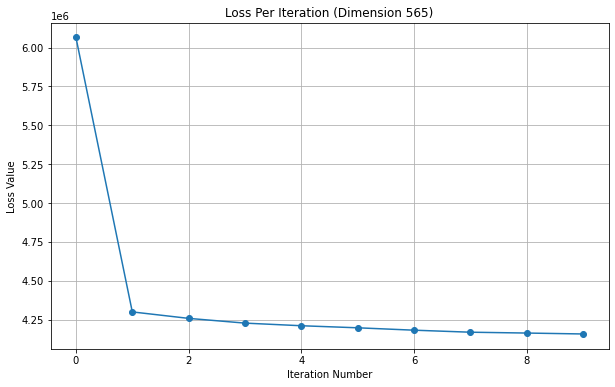

Embedding dimension: 565
PEARSON Mean similarity: 0.9044501965295969
EUCLIDEAN Mean similarity: 0.34294062829968497
COSINE Mean similarity: 0.9043921277653343
Number of matching relationships--PEARSON: 632
Number of matching relationships--EUCLIDEAN: 647
Number of matching relationships--COSINE: 634
[6076467.7290897295, 4298511.155189814, 4253589.740589268, 4225550.798996254, 4209581.7271644585, 4197053.386634201, 4180654.6082967496, 4168480.2554071415, 4161290.10006016, 4152538.4074417218]


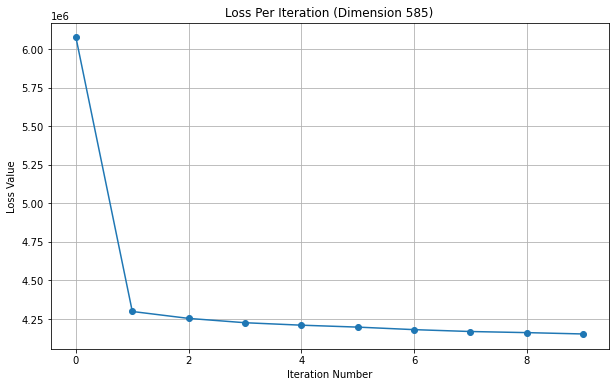

Embedding dimension: 585
PEARSON Mean similarity: 0.9041833240841481
EUCLIDEAN Mean similarity: 0.34254822111200195
COSINE Mean similarity: 0.9039086506673117
Number of matching relationships--PEARSON: 622
Number of matching relationships--EUCLIDEAN: 641
Number of matching relationships--COSINE: 621
[6070881.172609721, 4299740.024461461, 4255357.124643056, 4227602.883821108, 4204832.268372606, 4194521.62278747, 4182205.390247991, 4169110.094398275, 4164739.5954559, 4153563.0889399014]


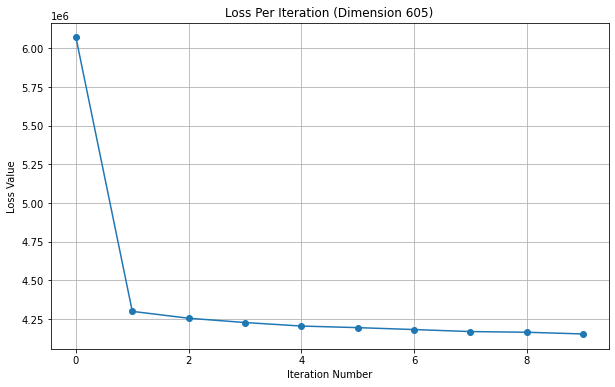

Embedding dimension: 605
PEARSON Mean similarity: 0.9043111412352615
EUCLIDEAN Mean similarity: 0.34272844435721417
COSINE Mean similarity: 0.9044914510436741
Number of matching relationships--PEARSON: 627
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 627
[6079280.7185532795, 4297828.679747888, 4254603.873011452, 4225899.273108698, 4211245.745630354, 4193778.3134496706, 4179410.622319399, 4172160.812396765, 4159266.459933868, 4152776.252979377]


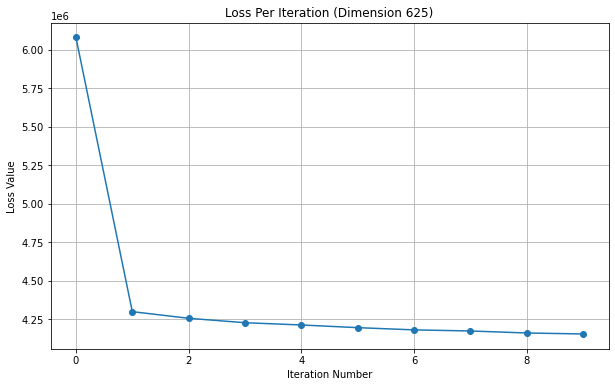

Embedding dimension: 625
PEARSON Mean similarity: 0.9045102056055336
EUCLIDEAN Mean similarity: 0.3430209597245277
COSINE Mean similarity: 0.9044384453462181
Number of matching relationships--PEARSON: 631
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 631
[6079794.463033184, 4299492.771770361, 4252957.273211087, 4228866.643041185, 4210604.995095546, 4195389.5558354575, 4178447.907729198, 4170985.03285698, 4161627.865357158, 4156761.7302391664]


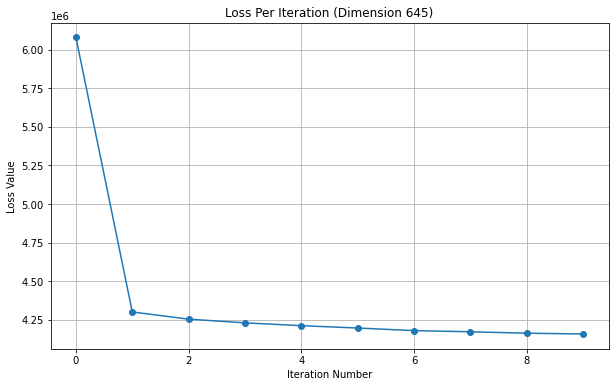

Embedding dimension: 645
PEARSON Mean similarity: 0.9040581014342991
EUCLIDEAN Mean similarity: 0.3431589482277852
COSINE Mean similarity: 0.9043010038322324
Number of matching relationships--PEARSON: 631
Number of matching relationships--EUCLIDEAN: 644
Number of matching relationships--COSINE: 630
[6046272.766888468, 4297268.5231854655, 4255537.899000927, 4232616.974221769, 4208232.13442828, 4194319.971546403, 4179831.917737171, 4173569.637753389, 4165330.3278582874, 4156576.2217713543]


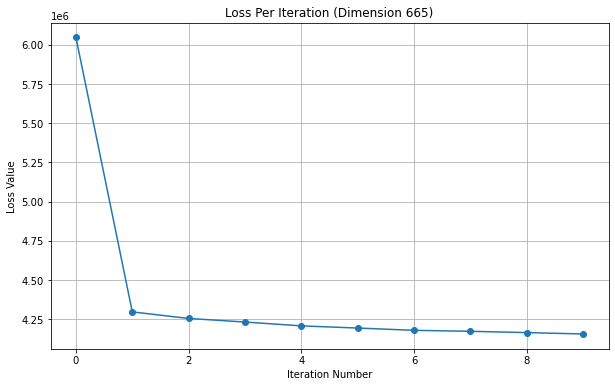

Embedding dimension: 665
PEARSON Mean similarity: 0.9041428130697816
EUCLIDEAN Mean similarity: 0.34297051302967607
COSINE Mean similarity: 0.9043545214429035
Number of matching relationships--PEARSON: 624
Number of matching relationships--EUCLIDEAN: 636
Number of matching relationships--COSINE: 628


In [6]:
for embedding_dimension in range(65, 666, 20):
    # 构建图名称
    graph_name = f"Cora--41-{embedding_dimension}"
    
    # 创建项目图
    G, _ = gds.graph.project(
        graph_name,
        {"Paper": {"properties": ["features"]}},
        {"CITES": {"orientation": "UNDIRECTED"}}
    )
    
    # 运行 FastRP 算法并修改投影图
    result = gds.node2vec.mutate(
        G,
        mutateProperty="N2V",
        randomSeed=42,
        embeddingDimension=embedding_dimension,
        iterations=10   
    )
    # 将节点属性写入图中
    graph = gds.graph.get(graph_name)
    gds.graph.writeNodeProperties(
        graph,
        ['N2V']
    )
    # 存储损失值
    losses = result['lossPerIteration']
    print(losses)
    plt.figure(figsize=(10, 6))
    plt.plot(losses, marker='o')  # 绘制损失值，'o'表示用圆圈标记每个点

    # 设置图表标题和轴标签
    plt.title(f'Loss Per Iteration (Dimension {embedding_dimension})')
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss Value')
    plt.grid(True)
    plt.show()
    
     # 第一次运行 k 最近邻算法，使用欧氏距离，写入关系类型为 "SIMILAR1"
    result_1 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=[{"N2V":'PEARSON'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR1",
        writeProperty="score1"
    )

    # 第二次运行 k 最近邻算法，使用角距离，写入关系类型为 "SIMILAR2"
    result_2 = gds.knn.write(
     G,
        topK=5,
        nodeProperties=[{"N2V":'EUCLIDEAN'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR2",
        writeProperty="score2"
    )
    # 第3次运行 k 最近邻算法，使用PEARSON，写入关系类型为 "SIMILAR3"
    result_3 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=["N2V"],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR3",
        writeProperty="score3",
        
    )

    
    # 输出结果信息
    print(f"Embedding dimension: {embedding_dimension}")
    print(f"PEARSON Mean similarity: {result_1['similarityDistribution']['mean']}")
    print(f"EUCLIDEAN Mean similarity: {result_2['similarityDistribution']['mean']}")
    print(f"COSINE Mean similarity: {result_3['similarityDistribution']['mean']}")

    # 比较数据
    similar1_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR1]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar1_relationships.add((record['node1'], record['node2']))
    
    matching1_relationships = similar1_relationships.intersection(file_similar_relationships)
    num1_matching_relationships = len(matching1_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--PEARSON: {num1_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR1]->() REMOVE r.score1 DELETE r")
    # 比较数据
    similar2_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR2]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar2_relationships.add((record['node1'], record['node2']))
    
    matching2_relationships = similar2_relationships.intersection(file_similar_relationships)
    num2_matching_relationships = len(matching2_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--EUCLIDEAN: {num2_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR2]->() REMOVE r.score2 DELETE r")
        
    
     # 比较数据
    similar3_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR3]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar3_relationships.add((record['node1'], record['node2']))
    
    matching3_relationships = similar3_relationships.intersection(file_similar_relationships)
    num3_matching_relationships = len(matching3_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--COSINE: {num3_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR3]->() REMOVE r.score3 DELETE r")
        
        
    # 获取嵌入数据并进行PCA降维
    #embedding_data = []
    #with driver.session() as session:
        #result = session.run(f"MATCH (n) WHERE n.N2V IS NOT NULL RETURN n.N2V AS N2V")
        #for record in result:
            #embedding_data.append(record['N2V'])
    #embedding_df = pd.DataFrame(embedding_data)
    #print(len(embedding_data))
    #print(embedding_df.info())
    #print(embedding_df.isna().sum())

    
    # 使用均值填充NaN值
    #imputer = SimpleImputer(strategy='mean')
    #embedding_df_filled = pd.DataFrame(imputer.fit_transform(embedding_df))
    
    # 进行PCA降维
    #pca = PCA(n_components=2)
    #principalComponents = pca.fit_transform(embedding_df_filled)
    #principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    
    # 绘制散点图
    #plt.scatter(principalDf['PC1'], principalDf['PC2'])
    #plt.xlabel('PC1')
    #plt.ylabel('PC2')
    #plt.title(f'PCA of Embedding Data (Dimension {embedding_dimension})')
    #plt.show()
    
    # 绘制损失值图表
    



        

[6057239.079887346, 4296040.988492977, 4254983.515166098, 4229415.727639898, 4213432.682560355, 4194898.666257698, 4181670.9540884653, 4172120.330009625, 4157860.003626209, 4154130.9572446723]


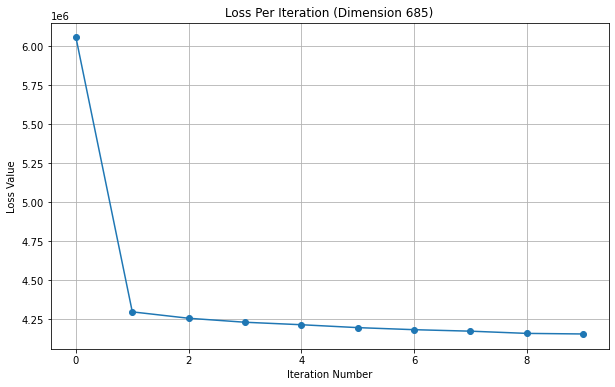

Embedding dimension: 685
PEARSON Mean similarity: 0.9041062119792448
EUCLIDEAN Mean similarity: 0.3431313163948904
COSINE Mean similarity: 0.9044932513328563
Number of matching relationships--PEARSON: 633
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 633
[6077977.367698334, 4300691.266976029, 4256758.398630418, 4230331.863528816, 4209899.869081589, 4196857.298368417, 4180644.908184567, 4174138.695937064, 4162331.1062220866, 4153425.1726426734]


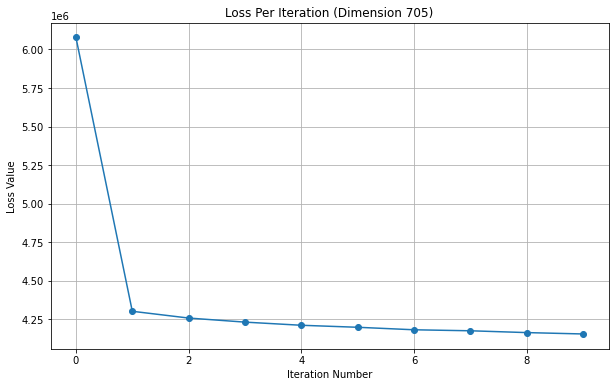

Embedding dimension: 705
PEARSON Mean similarity: 0.9043879200471909
EUCLIDEAN Mean similarity: 0.3432816075081311
COSINE Mean similarity: 0.9043051484416471
Number of matching relationships--PEARSON: 634
Number of matching relationships--EUCLIDEAN: 643
Number of matching relationships--COSINE: 632
[6078621.119741175, 4297664.32105765, 4254738.509356653, 4230514.851650077, 4211975.324559297, 4195776.056935199, 4181868.944147008, 4166621.3591715833, 4160972.7441216097, 4159130.2542161695]


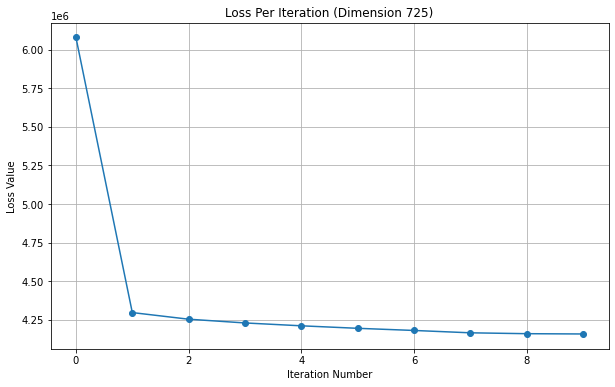

Embedding dimension: 725
PEARSON Mean similarity: 0.904324050351119
EUCLIDEAN Mean similarity: 0.34322744239908554
COSINE Mean similarity: 0.9040150032437887
Number of matching relationships--PEARSON: 629
Number of matching relationships--EUCLIDEAN: 646
Number of matching relationships--COSINE: 630
[6054934.978632934, 4302555.7856730735, 4258877.5871596, 4231990.205320817, 4210492.830086933, 4195926.146499623, 4178252.5954075246, 4169339.354357239, 4161961.811181345, 4152384.078722503]


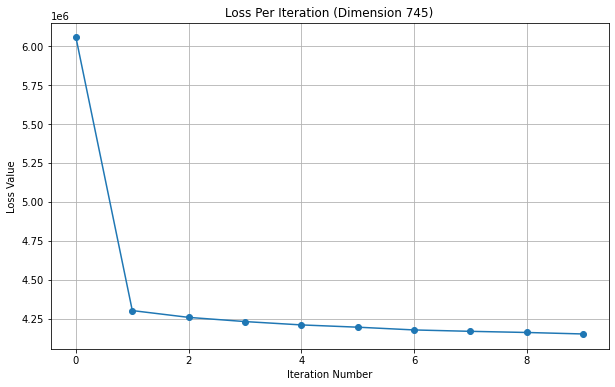

Embedding dimension: 745
PEARSON Mean similarity: 0.9042112102536718
EUCLIDEAN Mean similarity: 0.34301038753334845
COSINE Mean similarity: 0.9040678692004881
Number of matching relationships--PEARSON: 634
Number of matching relationships--EUCLIDEAN: 652
Number of matching relationships--COSINE: 634
[6081318.391685242, 4301941.141750962, 4256038.873635068, 4231620.814291155, 4209444.178278193, 4197839.387377739, 4181073.398081734, 4165013.967642512, 4160443.7513884916, 4156606.0611438826]


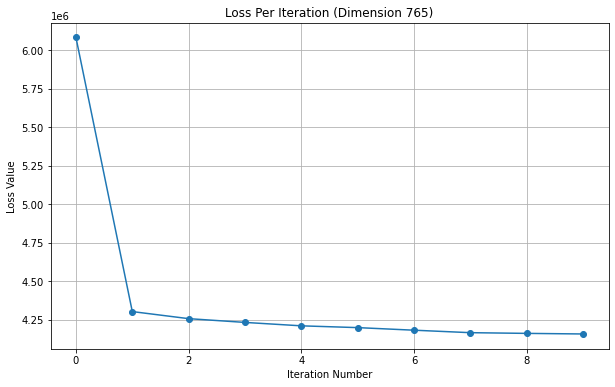

Embedding dimension: 765
PEARSON Mean similarity: 0.904333028976463
EUCLIDEAN Mean similarity: 0.3432002685270774
COSINE Mean similarity: 0.9044585533649213
Number of matching relationships--PEARSON: 629
Number of matching relationships--EUCLIDEAN: 643
Number of matching relationships--COSINE: 631
[6096053.400760389, 4293959.786409268, 4254803.282621654, 4232440.9711369425, 4209484.156973254, 4196547.726843374, 4186635.575559064, 4169706.148081259, 4164553.6574242255, 4154184.1090868763]


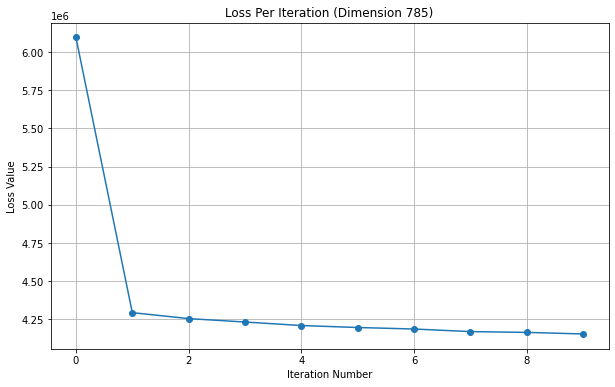

Embedding dimension: 785
PEARSON Mean similarity: 0.9043386600218284
EUCLIDEAN Mean similarity: 0.34323085949727317
COSINE Mean similarity: 0.9041159789002277
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 645
Number of matching relationships--COSINE: 630
[6094163.825740423, 4298405.853888585, 4253984.260823085, 4227823.090787411, 4213439.037123806, 4195972.284169775, 4181889.1487724697, 4169901.1402812107, 4158370.2868055664, 4152811.7999706194]


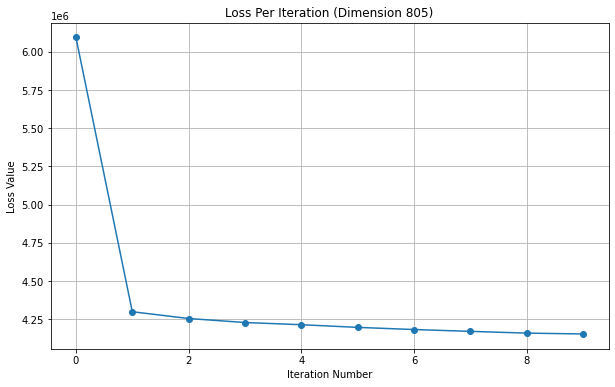

Embedding dimension: 805
PEARSON Mean similarity: 0.9042589917316747
EUCLIDEAN Mean similarity: 0.34330837976633183
COSINE Mean similarity: 0.9043312633407344
Number of matching relationships--PEARSON: 624
Number of matching relationships--EUCLIDEAN: 643
Number of matching relationships--COSINE: 625
[6091124.48210846, 4298668.971978722, 4258220.7689286005, 4230221.095826236, 4213254.204729862, 4190291.677041627, 4181388.6875821818, 4169465.802268459, 4162745.949437316, 4152191.5099494504]


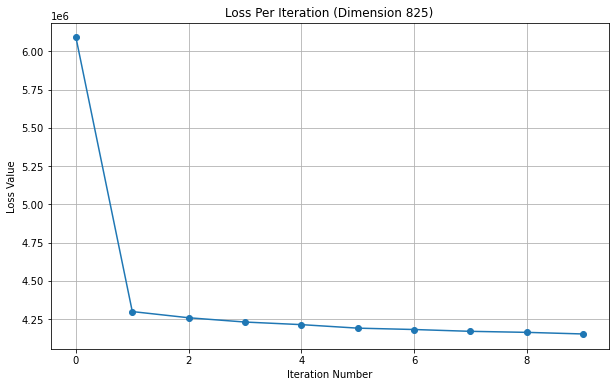

Embedding dimension: 825
PEARSON Mean similarity: 0.9040978712028379
EUCLIDEAN Mean similarity: 0.34337737239798205
COSINE Mean similarity: 0.904122399086438
Number of matching relationships--PEARSON: 624
Number of matching relationships--EUCLIDEAN: 641
Number of matching relationships--COSINE: 624
[6092737.836771482, 4304606.253793874, 4255863.229377883, 4228851.316592192, 4211353.441593712, 4193879.758830732, 4181257.442462145, 4170025.570560882, 4160899.469898176, 4152930.439842345]


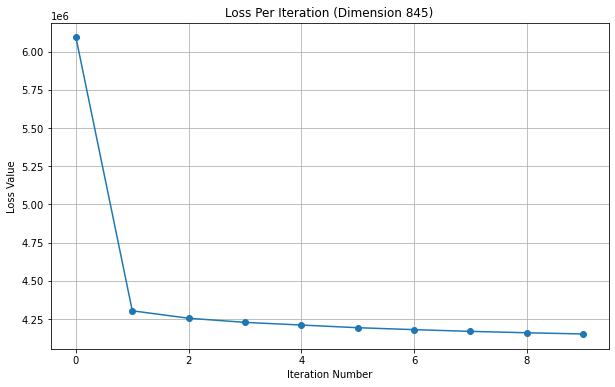

Embedding dimension: 845
PEARSON Mean similarity: 0.9043675773429025
EUCLIDEAN Mean similarity: 0.34370545108350026
COSINE Mean similarity: 0.9046038682562914
Number of matching relationships--PEARSON: 633
Number of matching relationships--EUCLIDEAN: 635
Number of matching relationships--COSINE: 633
[6095437.874170452, 4298583.032647645, 4258562.9045351455, 4231660.754347186, 4207944.550826855, 4196378.376998458, 4180763.9681514, 4168954.4768050415, 4160567.4969660253, 4155542.749071468]


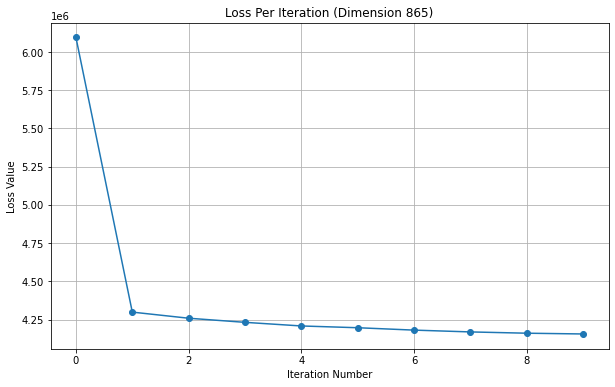

Embedding dimension: 865
PEARSON Mean similarity: 0.9042151883574673
EUCLIDEAN Mean similarity: 0.34365061706419003
COSINE Mean similarity: 0.9042677244020177
Number of matching relationships--PEARSON: 635
Number of matching relationships--EUCLIDEAN: 641
Number of matching relationships--COSINE: 635
[6100683.138999915, 4302714.288146027, 4253256.566211056, 4232336.046641136, 4207955.044579648, 4191921.2898756424, 4183791.4175198623, 4172981.140603363, 4161998.719066974, 4152101.780266618]


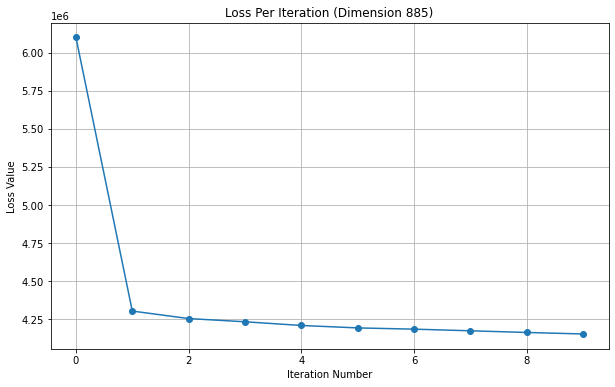

Embedding dimension: 885
PEARSON Mean similarity: 0.9042109169671243
EUCLIDEAN Mean similarity: 0.34357859824221454
COSINE Mean similarity: 0.9043222086468334
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 625
[6078264.600293264, 4301424.031494208, 4255267.767125513, 4230637.399367019, 4211242.940501962, 4195097.446133877, 4181965.303743323, 4169266.609254282, 4164145.9040498696, 4159463.192364946]


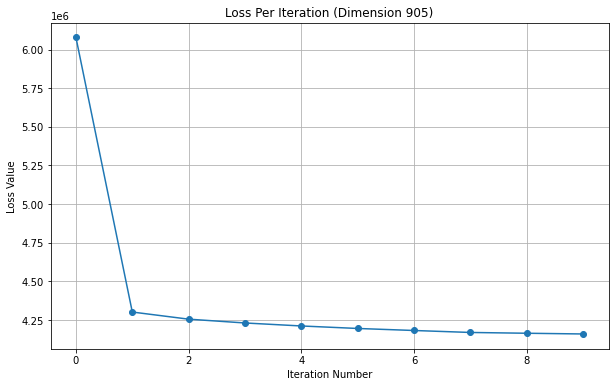

Embedding dimension: 905
PEARSON Mean similarity: 0.9040821447330176
EUCLIDEAN Mean similarity: 0.3438437154057107
COSINE Mean similarity: 0.9041288981585595
Number of matching relationships--PEARSON: 634
Number of matching relationships--EUCLIDEAN: 646
Number of matching relationships--COSINE: 633
[6100947.541513124, 4301930.728734484, 4256522.513514657, 4227293.952128068, 4208269.286179772, 4194735.149560582, 4184974.127759196, 4169532.129029412, 4165158.6981001287, 4153984.4001714103]


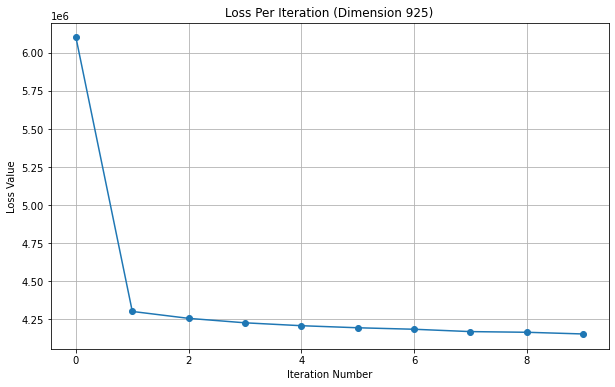

Embedding dimension: 925
PEARSON Mean similarity: 0.9042460648664872
EUCLIDEAN Mean similarity: 0.3436221059351235
COSINE Mean similarity: 0.9044986879807984
Number of matching relationships--PEARSON: 632
Number of matching relationships--EUCLIDEAN: 646
Number of matching relationships--COSINE: 634
[6116206.753376877, 4296648.092167848, 4261321.977466879, 4230612.319944756, 4214238.357831754, 4194974.026685093, 4183567.9690515082, 4170752.5804949235, 4164863.0058936607, 4156939.490371226]


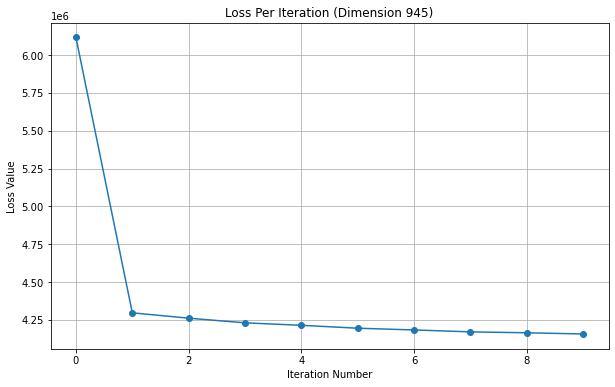

Embedding dimension: 945
PEARSON Mean similarity: 0.9043426905284075
EUCLIDEAN Mean similarity: 0.3438097137468076
COSINE Mean similarity: 0.9044855120615205
Number of matching relationships--PEARSON: 627
Number of matching relationships--EUCLIDEAN: 642
Number of matching relationships--COSINE: 631
[6111442.248440595, 4302150.452518694, 4252904.229430642, 4231117.436708504, 4208689.835913911, 4195652.302548449, 4179505.1606567404, 4170930.574605756, 4167105.8714216133, 4154641.853985739]


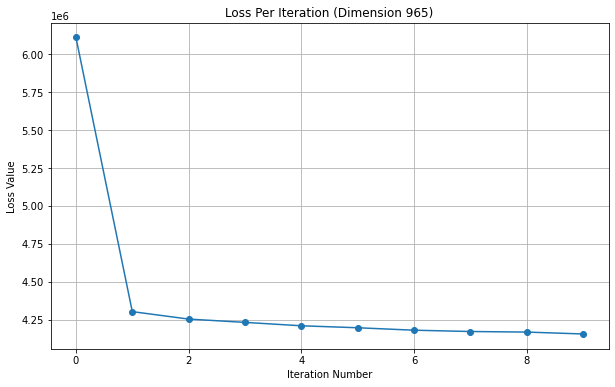

Embedding dimension: 965
PEARSON Mean similarity: 0.9044317113067762
EUCLIDEAN Mean similarity: 0.343874703693249
COSINE Mean similarity: 0.9043584178434341
Number of matching relationships--PEARSON: 629
Number of matching relationships--EUCLIDEAN: 647
Number of matching relationships--COSINE: 628
[6084608.597861104, 4298419.626675557, 4256228.053733421, 4229689.154631051, 4215309.222114534, 4200840.784709983, 4185636.508030059, 4173481.276002934, 4159241.4337971397, 4156010.188483618]


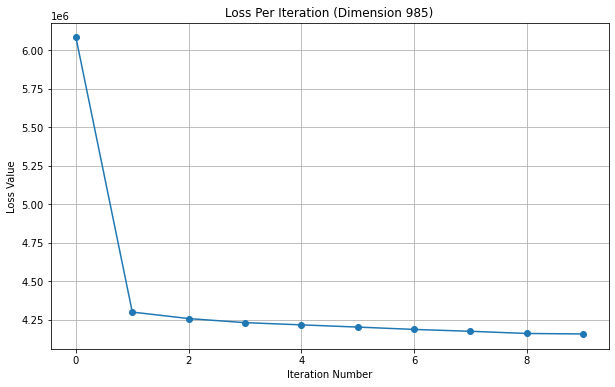

Embedding dimension: 985
PEARSON Mean similarity: 0.9042272463506926
EUCLIDEAN Mean similarity: 0.34368648902352134
COSINE Mean similarity: 0.9041986282326094
Number of matching relationships--PEARSON: 629
Number of matching relationships--EUCLIDEAN: 645
Number of matching relationships--COSINE: 633
[6112170.966420652, 4297835.252176315, 4259533.780030678, 4229740.80843689, 4209417.142964881, 4196278.340959745, 4184172.3569164504, 4171955.2516489127, 4161344.6305249343, 4157360.9703598847]


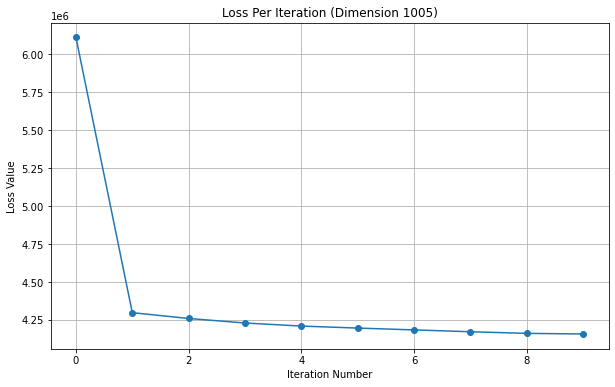

Embedding dimension: 1005
PEARSON Mean similarity: 0.9043696557049209
EUCLIDEAN Mean similarity: 0.34374307621176875
COSINE Mean similarity: 0.9045581099201693
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 640
Number of matching relationships--COSINE: 630
[6103924.723303133, 4302652.078287401, 4253493.875602235, 4227227.966322633, 4210227.853115536, 4195682.479106981, 4176885.8292162707, 4170747.837680503, 4160965.105507168, 4157071.089680046]


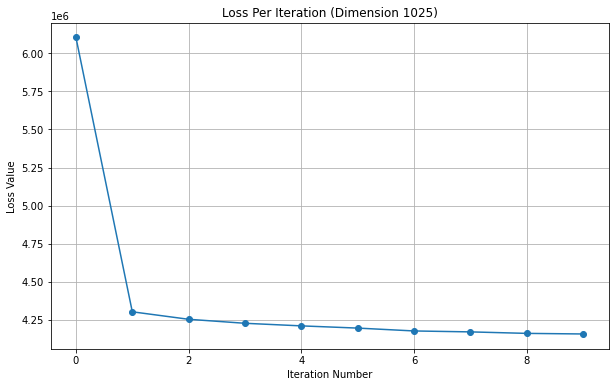

Embedding dimension: 1025
PEARSON Mean similarity: 0.9046057685615393
EUCLIDEAN Mean similarity: 0.344031141568498
COSINE Mean similarity: 0.9044124932901898
Number of matching relationships--PEARSON: 633
Number of matching relationships--EUCLIDEAN: 643
Number of matching relationships--COSINE: 629
[6118436.050311854, 4300082.967586911, 4255584.32080235, 4230337.084215631, 4208113.684951444, 4194436.533549336, 4179808.056638784, 4171704.1491096797, 4162156.5393342446, 4156331.3787497273]


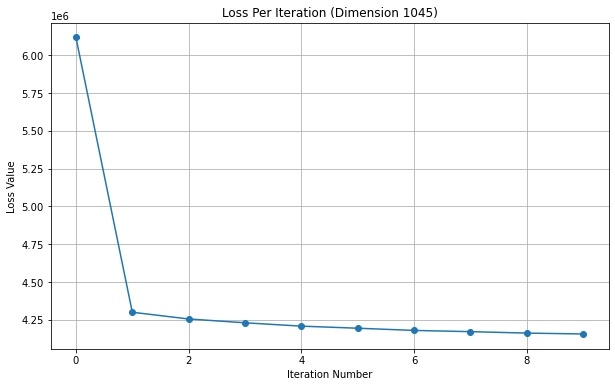

Embedding dimension: 1045
PEARSON Mean similarity: 0.9043185381980907
EUCLIDEAN Mean similarity: 0.343687291828533
COSINE Mean similarity: 0.9041285485249326
Number of matching relationships--PEARSON: 628
Number of matching relationships--EUCLIDEAN: 627
Number of matching relationships--COSINE: 625
[6094296.057230148, 4301795.175141901, 4259295.411659789, 4231431.924648377, 4209650.091660712, 4195210.428422944, 4183404.6683308403, 4170170.95509516, 4161138.6671289774, 4154020.8475964554]


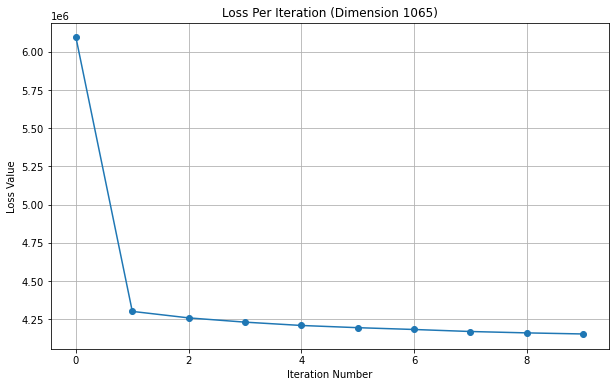

Embedding dimension: 1065
PEARSON Mean similarity: 0.9042991480411772
EUCLIDEAN Mean similarity: 0.34403521123629727
COSINE Mean similarity: 0.9042770211066242
Number of matching relationships--PEARSON: 632
Number of matching relationships--EUCLIDEAN: 644
Number of matching relationships--COSINE: 631
[6101347.366813464, 4301513.703144243, 4253182.08594501, 4227100.184120265, 4209047.111753337, 4192758.360563533, 4181400.5236672703, 4172880.751147477, 4164264.52563816, 4155991.4913080847]


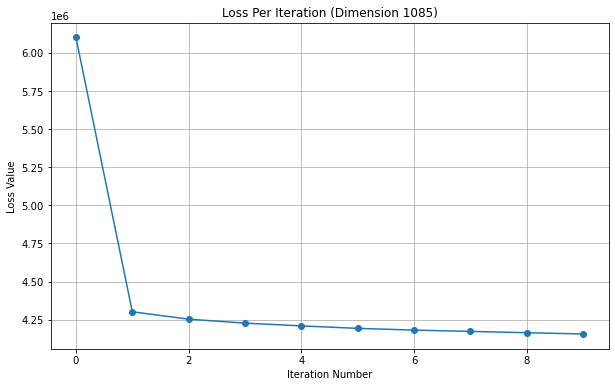

Embedding dimension: 1085
PEARSON Mean similarity: 0.9043153900867728
EUCLIDEAN Mean similarity: 0.3438014310783262
COSINE Mean similarity: 0.9043325226979558
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 639
Number of matching relationships--COSINE: 626
[6117386.459819261, 4299748.628731675, 4258155.488671518, 4232078.024619526, 4213842.098293813, 4200399.43609126, 4183067.202774581, 4171284.114222489, 4160040.1582389977, 4155379.683650423]


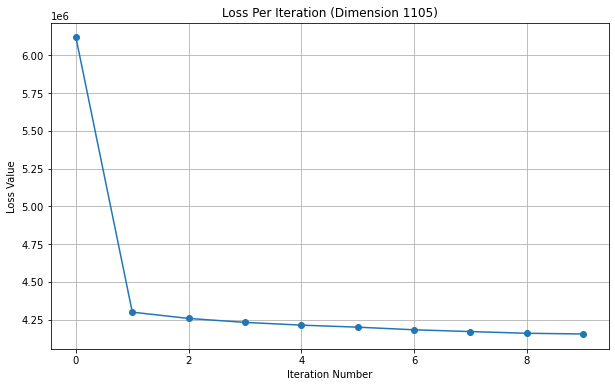

Embedding dimension: 1105
PEARSON Mean similarity: 0.9047110570234245
EUCLIDEAN Mean similarity: 0.34405207831186946
COSINE Mean similarity: 0.9044552962220049
Number of matching relationships--PEARSON: 636
Number of matching relationships--EUCLIDEAN: 638
Number of matching relationships--COSINE: 630
[6119260.871597962, 4301030.4325865265, 4256697.876863211, 4227315.322625108, 4215638.172128886, 4194709.8717632145, 4180432.839141152, 4175267.9276078385, 4162253.9356494015, 4154928.061221025]


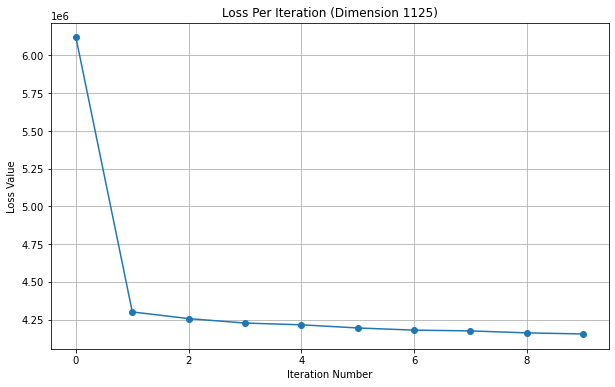

Embedding dimension: 1125
PEARSON Mean similarity: 0.9043129849116947
EUCLIDEAN Mean similarity: 0.3440293861456777
COSINE Mean similarity: 0.9042681154507478
Number of matching relationships--PEARSON: 625
Number of matching relationships--EUCLIDEAN: 648
Number of matching relationships--COSINE: 626
[6094799.087514361, 4299394.266384188, 4253509.502800984, 4226838.847493634, 4210806.837178803, 4193864.9105851175, 4180571.7603702545, 4172592.5274353735, 4162915.858607511, 4155901.883388365]


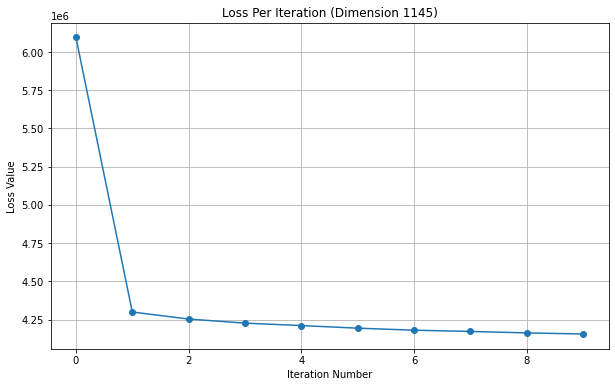

Embedding dimension: 1145
PEARSON Mean similarity: 0.9044267507916539
EUCLIDEAN Mean similarity: 0.3437765187667779
COSINE Mean similarity: 0.9043499638093979
Number of matching relationships--PEARSON: 639
Number of matching relationships--EUCLIDEAN: 652
Number of matching relationships--COSINE: 636
[6116559.029901898, 4299670.787803523, 4259083.923450363, 4228949.311391169, 4210564.000454803, 4198198.910720809, 4187397.140983826, 4171952.0884032506, 4159816.8927647234, 4153756.4208581736]


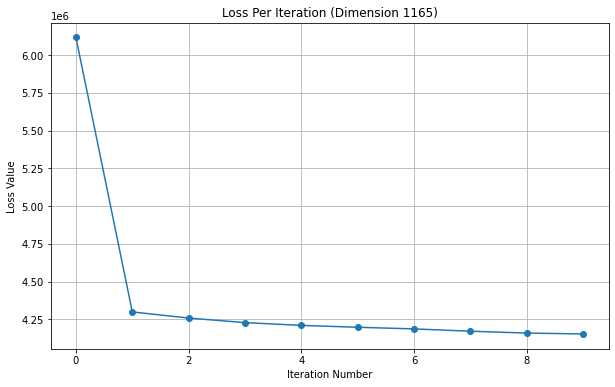

Embedding dimension: 1165
PEARSON Mean similarity: 0.9046056871400098
EUCLIDEAN Mean similarity: 0.34399135722015245
COSINE Mean similarity: 0.9045048002302206
Number of matching relationships--PEARSON: 634
Number of matching relationships--EUCLIDEAN: 647
Number of matching relationships--COSINE: 629
[6098939.0465518255, 4299766.359741903, 4256781.368566061, 4234441.170688384, 4215460.065482852, 4196089.967496756, 4181166.4454739895, 4170184.3292322424, 4161317.2012759773, 4155445.547845625]


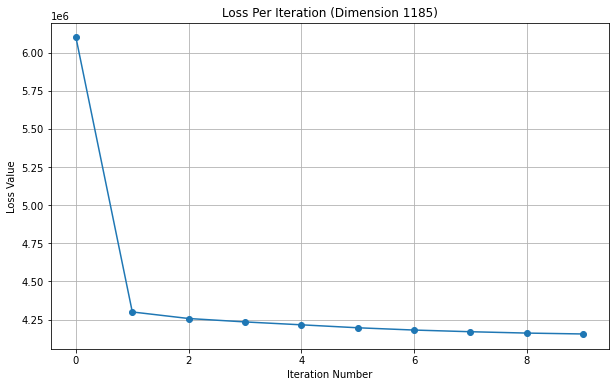

Embedding dimension: 1185
PEARSON Mean similarity: 0.9040702481741744
EUCLIDEAN Mean similarity: 0.34398068804156307
COSINE Mean similarity: 0.9043254147956431
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 649
Number of matching relationships--COSINE: 631
[6130185.96538312, 4299774.004832536, 4255872.698829565, 4233315.6562060835, 4211492.791601313, 4198136.9921304835, 4183860.305617726, 4171215.7971636197, 4163839.9466139367, 4159427.6959029087]


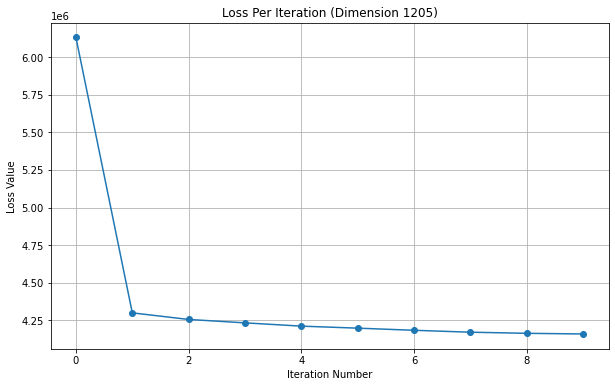

Embedding dimension: 1205
PEARSON Mean similarity: 0.9044700309832304
EUCLIDEAN Mean similarity: 0.3442642476040996
COSINE Mean similarity: 0.9045307103076748
Number of matching relationships--PEARSON: 624
Number of matching relationships--EUCLIDEAN: 645
Number of matching relationships--COSINE: 627
[6103892.55577773, 4300207.831692472, 4257944.9200094845, 4229814.776037049, 4208690.2598094735, 4196846.394709421, 4187429.6213457026, 4170204.6389363036, 4162704.7390050734, 4155647.5655970983]


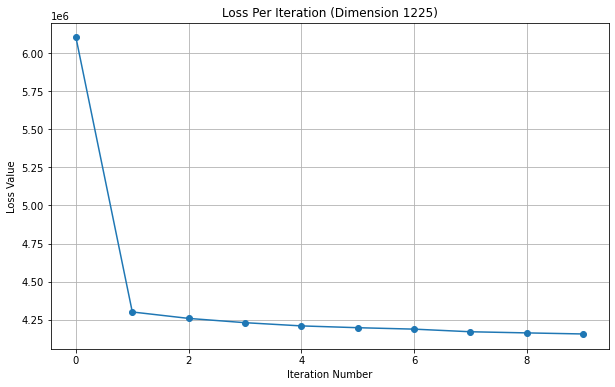

Embedding dimension: 1225
PEARSON Mean similarity: 0.9045496919482638
EUCLIDEAN Mean similarity: 0.34470626445077196
COSINE Mean similarity: 0.9045331721115676
Number of matching relationships--PEARSON: 630
Number of matching relationships--EUCLIDEAN: 643
Number of matching relationships--COSINE: 627
[6113262.915596962, 4298718.353436403, 4256779.0609127665, 4229223.699646336, 4210813.6741306335, 4196530.337983615, 4181583.6052221986, 4172335.1032256745, 4163788.170957185, 4158272.191006861]


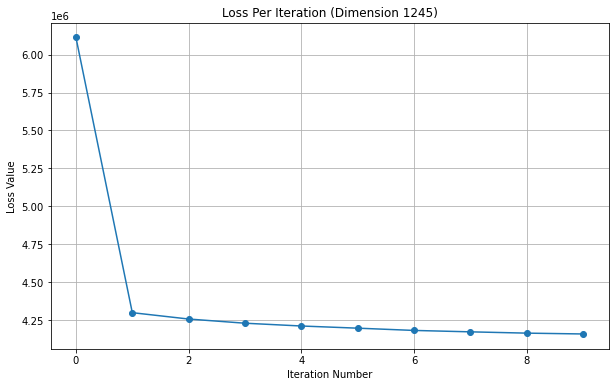

Embedding dimension: 1245
PEARSON Mean similarity: 0.9043882832041167
EUCLIDEAN Mean similarity: 0.34427394233038716
COSINE Mean similarity: 0.9043040212183266
Number of matching relationships--PEARSON: 629
Number of matching relationships--EUCLIDEAN: 646
Number of matching relationships--COSINE: 629
[6135511.443470084, 4298306.568125915, 4262095.876658207, 4234038.63030334, 4209941.449013263, 4199405.529034329, 4180583.6379593294, 4173457.9141750485, 4163311.9992041048, 4156098.932177159]


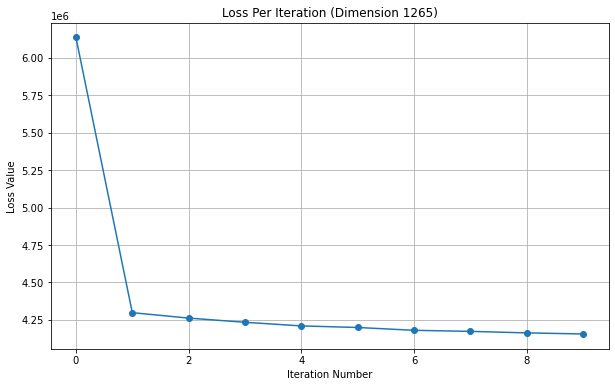

Embedding dimension: 1265
PEARSON Mean similarity: 0.9045846584100314
EUCLIDEAN Mean similarity: 0.34439144606428274
COSINE Mean similarity: 0.9045256111787376
Number of matching relationships--PEARSON: 634
Number of matching relationships--EUCLIDEAN: 649
Number of matching relationships--COSINE: 633
[6110895.459922119, 4301575.72561925, 4254008.429722363, 4229807.132430209, 4210703.487886657, 4196422.24874567, 4184250.4459362393, 4168279.7912669512, 4164593.7389339563, 4159456.7991768736]


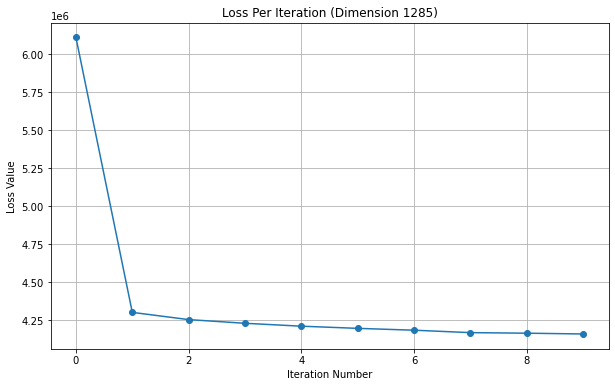

Embedding dimension: 1285
PEARSON Mean similarity: 0.9044869737047565
EUCLIDEAN Mean similarity: 0.3443318301500915
COSINE Mean similarity: 0.9045823586039916
Number of matching relationships--PEARSON: 623
Number of matching relationships--EUCLIDEAN: 645
Number of matching relationships--COSINE: 624


In [7]:
for embedding_dimension in range(685, 1286, 20):
    # 构建图名称
    graph_name = f"Cora--41-{embedding_dimension}"
    
    # 创建项目图
    G, _ = gds.graph.project(
        graph_name,
        {"Paper": {"properties": ["features"]}},
        {"CITES": {"orientation": "UNDIRECTED"}}
    )
    
    # 运行 FastRP 算法并修改投影图
    result = gds.node2vec.mutate(
        G,
        mutateProperty="N2V",
        randomSeed=42,
        embeddingDimension=embedding_dimension,
        iterations=10   
    )
    # 将节点属性写入图中
    graph = gds.graph.get(graph_name)
    gds.graph.writeNodeProperties(
        graph,
        ['N2V']
    )
    # 存储损失值
    losses = result['lossPerIteration']
    print(losses)
    plt.figure(figsize=(10, 6))
    plt.plot(losses, marker='o')  # 绘制损失值，'o'表示用圆圈标记每个点

    # 设置图表标题和轴标签
    plt.title(f'Loss Per Iteration (Dimension {embedding_dimension})')
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss Value')
    plt.grid(True)
    plt.show()
    
     # 第一次运行 k 最近邻算法，使用欧氏距离，写入关系类型为 "SIMILAR1"
    result_1 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=[{"N2V":'PEARSON'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR1",
        writeProperty="score1"
    )

    # 第二次运行 k 最近邻算法，使用角距离，写入关系类型为 "SIMILAR2"
    result_2 = gds.knn.write(
     G,
        topK=5,
        nodeProperties=[{"N2V":'EUCLIDEAN'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR2",
        writeProperty="score2"
    )
    # 第3次运行 k 最近邻算法，使用PEARSON，写入关系类型为 "SIMILAR3"
    result_3 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=["N2V"],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR3",
        writeProperty="score3",
        
    )

    
    # 输出结果信息
    print(f"Embedding dimension: {embedding_dimension}")
    print(f"PEARSON Mean similarity: {result_1['similarityDistribution']['mean']}")
    print(f"EUCLIDEAN Mean similarity: {result_2['similarityDistribution']['mean']}")
    print(f"COSINE Mean similarity: {result_3['similarityDistribution']['mean']}")

    # 比较数据
    similar1_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR1]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar1_relationships.add((record['node1'], record['node2']))
    
    matching1_relationships = similar1_relationships.intersection(file_similar_relationships)
    num1_matching_relationships = len(matching1_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--PEARSON: {num1_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR1]->() REMOVE r.score1 DELETE r")
    # 比较数据
    similar2_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR2]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar2_relationships.add((record['node1'], record['node2']))
    
    matching2_relationships = similar2_relationships.intersection(file_similar_relationships)
    num2_matching_relationships = len(matching2_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--EUCLIDEAN: {num2_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR2]->() REMOVE r.score2 DELETE r")
        
    
     # 比较数据
    similar3_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR3]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar3_relationships.add((record['node1'], record['node2']))
    
    matching3_relationships = similar3_relationships.intersection(file_similar_relationships)
    num3_matching_relationships = len(matching3_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--COSINE: {num3_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR3]->() REMOVE r.score3 DELETE r")

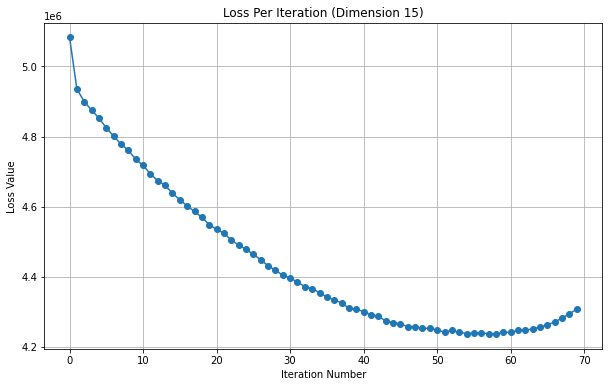

Embedding dimension: 15
PEARSON Mean similarity: 0.964466479539519
EUCLIDEAN Mean similarity: 0.42012490416207027
COSINE Mean similarity: 0.963988421058373
Number of matching relationships--PEARSON: 658
Number of matching relationships--EUCLIDEAN: 657
Number of matching relationships--COSINE: 661


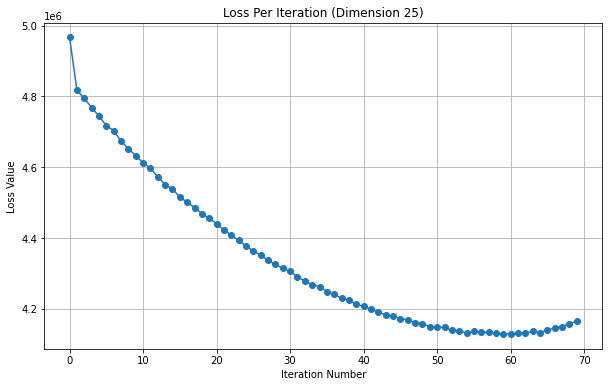

Embedding dimension: 25
PEARSON Mean similarity: 0.946061158567623
EUCLIDEAN Mean similarity: 0.3774523903383286
COSINE Mean similarity: 0.9452522322909694
Number of matching relationships--PEARSON: 655
Number of matching relationships--EUCLIDEAN: 667
Number of matching relationships--COSINE: 659


ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.writeNodeProperties`: Caused by: java.lang.OutOfMemoryError: Java heap space}

In [30]:
from neo4j import GraphDatabase
import pandas as pd
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import random

# 设置随机种子
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# 读取数据文件
CORA_CITES = pd.read_csv('remaining_paper_pairs.csv')
file_similar_relationships = set(zip(CORA_CITES.iloc[:, 0], CORA_CITES.iloc[:, 1]))

# Neo4j 驱动程序
driver = GraphDatabase.driver("bolt://localhost:7687", auth=('neo4j', '88888888'))
# 循环
for embedding_dimension in range(15,56,10):
    # 构建图名称
    graph_name = f"Cora--65-{embedding_dimension}"
    
    # 创建项目图
    G, _ = gds.graph.project(
        graph_name,
        {"Paper": {"properties": ["features"]}},
        {"CITES": {"orientation": "UNDIRECTED"}}
    )
    
    # 运行 FastRP 算法并修改投影图
    result = gds.node2vec.mutate(
        G,
        mutateProperty="N2V",
        randomSeed=42,
        embeddingDimension=embedding_dimension,
        iterations=70,
        walkLength=100,
        initialLearningRate=0.15,
        inOutFactor=3
    )
    # 将节点属性写入图中
    graph = gds.graph.get(graph_name)
    gds.graph.writeNodeProperties(
        graph,
        ['N2V']
    )
    # 存储损失值
    losses = result['lossPerIteration']
    #print(losses)
    plt.figure(figsize=(10, 6))
    plt.plot(losses, marker='o')  # 绘制损失值，'o'表示用圆圈标记每个点

    # 设置图表标题和轴标签
    plt.title(f'Loss Per Iteration (Dimension {embedding_dimension})')
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss Value')
    plt.grid(True)
    plt.show()
    
     # 第一次运行 k 最近邻算法，使用欧氏距离，写入关系类型为 "SIMILAR1"
    result_1 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=[{"N2V":'PEARSON'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR1",
        writeProperty="score1"
    )

    # 第二次运行 k 最近邻算法，使用角距离，写入关系类型为 "SIMILAR2"
    result_2 = gds.knn.write(
     G,
        topK=5,
        nodeProperties=[{"N2V":'EUCLIDEAN'}],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR2",
        writeProperty="score2"
    )
    # 第3次运行 k 最近邻算法，使用PEARSON，写入关系类型为 "SIMILAR3"
    result_3 = gds.knn.write(
        G,
        topK=5,
        nodeProperties=["N2V"],
        randomSeed=random_seed,
        concurrency=1,
        sampleRate=1.0,
        initialSampler="randomWalk",
        deltaThreshold=0.0,
        writeRelationshipType="SIMILAR3",
        writeProperty="score3",
        
    )

    
    # 输出结果信息
    print(f"Embedding dimension: {embedding_dimension}")
    print(f"PEARSON Mean similarity: {result_1['similarityDistribution']['mean']}")
    print(f"EUCLIDEAN Mean similarity: {result_2['similarityDistribution']['mean']}")
    print(f"COSINE Mean similarity: {result_3['similarityDistribution']['mean']}")

    # 比较数据
    similar1_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR1]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar1_relationships.add((record['node1'], record['node2']))
    
    matching1_relationships = similar1_relationships.intersection(file_similar_relationships)
    num1_matching_relationships = len(matching1_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--PEARSON: {num1_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR1]->() REMOVE r.score1 DELETE r")
        session.run("MATCH (n) WHERE n.N2V IS NOT NULL REMOVE n.N2V")
    # 比较数据
    similar2_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR2]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar2_relationships.add((record['node1'], record['node2']))
    
    matching2_relationships = similar2_relationships.intersection(file_similar_relationships)
    num2_matching_relationships = len(matching2_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--EUCLIDEAN: {num2_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR2]->() REMOVE r.score2 DELETE r")
        session.run("MATCH (n) WHERE n.N2V IS NOT NULL REMOVE n.N2V")
        
    
     # 比较数据
    similar3_relationships = set()
    with driver.session() as session:
        result = session.run("MATCH (n1)-[r:SIMILAR3]->(n2) RETURN n1.extId AS node1, n2.extId AS node2")
        for record in result:
            similar3_relationships.add((record['node1'], record['node2']))
    
    matching3_relationships = similar3_relationships.intersection(file_similar_relationships)
    num3_matching_relationships = len(matching3_relationships)
    
    # 输出匹配的 similar 关系数量
    print(f"Number of matching relationships--COSINE: {num3_matching_relationships}")
    
    # 执行 Cypher 查询并删除 similar 关系和 score1 属性
    with driver.session() as session:
        session.run("MATCH p=()-[r:SIMILAR3]->() REMOVE r.score3 DELETE r")
        session.run("MATCH (n) WHERE n.N2V IS NOT NULL REMOVE n.N2V")
        
        